## RL Merged with Plots

### With variable Transmission Energy

In [ ]:
node_energy_ = {
    2: 0.5,  # Sensor 2 consumes 0.5 energy per data addition
    3: 0.7,  # Sensor 3 consumes 0.7 energy per data addition
    4: 2.4,  # Sensor 4 consumes 0.6 energy per data addition
    5: 1.3,  # Sensor 5 consumes 0.8 energy per data addition
    6: 0.45,  # Sensor 6 consumes 0.4 energy per data addition
    7: 1.8,  # Sensor 7 consumes 0.9 energy per data addition
    8: 0.3,  # Sensor 8 consumes 0.3 energy per data addition
    9: 2.8,  # Sensor 9 consumes 0.7 energy per data addition
    10: 0.6,  # Sensor 10 consumes 0.6 energy per data addition
    11: 1.5,  # Sensor 11 consumes 0.5 energy per data addition
    12: 0.9   # Sensor 12 consumes 0.9 energy per data addition
}
tower_distances = [0, 12, 1.3993, 1.3976, 0.7614, 18, 0.9246, 1.8231, 1.8018, 12]

In [ ]:
import numpy as np
import pandas as pd
from collections import deque, defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm

class SensorNode:
    def __init__(self, sensor_id, buffer_size=100, flush_size=10, initial_energy=100, recharge_threshold=20, recharge_time=3):
        # Basic sensor properties
        self.sensor_id = sensor_id
        self.initial_energy = initial_energy
        self.energy = initial_energy
        self.recharge_threshold = recharge_threshold
        self.recharge_time = recharge_time
        self.recharge_count = 0
        self.recharge_end_time = 0

        # Buffer management
        self.buffer = deque(maxlen=buffer_size)
        self.flush_size = flush_size
        self.flush_log = []

        # Monitoring variables
        self.energy_over_time = []
        self.recharge_over_time = []
        self.latest_timestamp_over_time = []
        ###
        self.node_energy = node_energy_
        # RL-specific properties
        self.previous_frequency = 1

    def add_data(self, row, global_time):
        if global_time < self.recharge_end_time:
            self.energy_over_time.append((global_time, self.energy))
            if self.buffer:
                self.latest_timestamp_over_time.append((global_time, self.buffer[-1]['Timestamp']))
            return

        # self.energy -= 1
        self.energy -= (self.node_energy[self.sensor_id]) * 3
        self.energy_over_time.append((global_time, self.energy))

        self.buffer.append(row)
        self.latest_timestamp_over_time.append((global_time, row['Timestamp']))

        if self.energy < self.recharge_threshold:
            self.recharge(global_time)

        if len(self.buffer) == self.buffer.maxlen:
            self.flush_data()

    def flush_data(self):
        flushed_values = [self.buffer.popleft() for _ in range(self.flush_size)]
        self.flush_log.append(flushed_values)

    def recharge(self, global_time):
        self.recharge_count += 3
        self.energy = self.initial_energy
        self.recharge_end_time = global_time + self.recharge_time
        self.recharge_over_time.append((global_time, self.recharge_count))

    def update_energy(self, global_time):
        if global_time >= self.recharge_end_time:
            self.energy -= self.node_energy[self.sensor_id]
            if self.energy < self.recharge_threshold:
                self.recharge(global_time)

    # def calculate_energy(d, d_0=0.01, K=10, a=1, E_0=0):
    #     return E_0 + K / (1 + np.exp(-a * (d - d_0)))
    # cluster_head = "towerData_1"
    # distances_to_cluster_head = distance_matrix[cluster_head].astype(float)
    # energy_consumption = distances_to_cluster_head.apply(calculate_energy)

class RLScheduler:
    def __init__(self, num_sensors, state_size, action_size, num_levels):
        self.num_sensors = num_sensors
        self.state_size = state_size
        self.action_size = action_size
        self.q_table = defaultdict(lambda: np.zeros(action_size))  # Initialize Q-table with zeros
        self.num_levels = num_levels

    def get_action(self, state, training=True, epsilon=0.2):
        """
        Epsilon-greedy action selection for exploration and exploitation.
        """
        if training and np.random.rand() < epsilon:
            # Exploration: choose a random action
            return np.random.choice(self.action_size)
        else:
            # Exploitation: choose the action with the highest Q-value
            return np.argmax(self.q_table[state])


    def update_q_value(self, state, action, reward, next_state, alpha=0.1, gamma=0.9):
        """
        Update Q-value using the simple Q-learning update rule.
        """
        max_next_q = np.max(self.q_table[next_state])  # Max Q-value for the next state
        self.q_table[state][action] += alpha * (reward + (gamma * max_next_q - self.q_table[state][action]))


class WSNEnvironment:
    def __init__(self):
        self.sensors = {}
        self.global_time = 0
        self.scheduler = None
        self.discrete_threshold = [0.25, 0.50002455, 0.75]

    def add_sensor(self, sensor_id, buffer_size=100, flush_size=10, initial_energy=100, recharge_threshold=20, recharge_time=3):
        self.sensors[sensor_id] = SensorNode(sensor_id, buffer_size, flush_size, initial_energy, recharge_threshold, recharge_time)

    def initialize_scheduler(self, state_size, action_size, num_levels):


        self.scheduler = RLScheduler(
            num_sensors=len(self.sensors),
            state_size=state_size,
            action_size=action_size,
            num_levels=num_levels
        )

        print("  Scheduler created successfully")


    def calculate_reward(self, f_i, discrete_similarity, lambda_param=0.01):
        reward = -1 * (discrete_similarity)
        reward += (-(f_i) * 0.01)

        return reward

    def calculate_similarity(self, sensor_data, step):
        """
        Calculate similarities between sensors at a given time step

        Args:
            sensor_data (dict): Dictionary of sensor dataframes
            step (int): Current time step

        Returns:
            dict: Similarities between sensor pairs
        """
        # Round temperature values to 3 decimal places
        rounded_values = {
            sensor_id: round(df.loc[step, "Temperature_2m"], 2)
            for sensor_id, df in sensor_data.items()
        }

        # Compute similarities
        similarities = {}
        sensor_ids = list(rounded_values.keys())

        for i in range(len(sensor_ids)):
            for j in range(i + 1, len(sensor_ids)):
                sensor_i = sensor_ids[i]
                sensor_j = sensor_ids[j]

                # Simple dot product similarity
                value_i = rounded_values[sensor_i]
                value_j = rounded_values[sensor_j]

                # Compute dot product similarity
                similarity = abs(value_i * value_j) / (abs(value_i) + abs(value_j) + 1e-10)

                similarities[(sensor_i, sensor_j)] = similarity

        return similarities




    def calculate_similarity_score(self, sensor_id, similarites, alpha=1, beta=1):
        similarity = 0.0
        n = len(similarites)
        for (i, j), jaccard in similarites.items():
            if sensor_id == i or sensor_id == j:
                similarity += alpha * jaccard
        aggregated_similarity = similarity / max(n, 1)
        buffer_margin=0.01
        # Define robust min and max (static or dynamic)
        current_min = 0.0227  # Replace with observed min_similarity or predefined value
        current_max = 0.0826  # Replace with observed max_similarity or predefined value
        min_similarity = current_min - buffer_margin
        max_similarity = current_max + buffer_margin

        # Clamp values to handle outliers
        clamped_similarity = max(min(aggregated_similarity, max_similarity), min_similarity)

        # Normalize to range [0, 1]
        normalized_similarity = (clamped_similarity - min_similarity) / (max_similarity - min_similarity)

        return normalized_similarity
    def get_similarity_level(self, similarity_value):
        """
        Map a single similarity value to its corresponding level based on class variable discrete_threshold.

        Args:
            similarity_value (float): The similarity value to map to a level.

        Returns:
            int: The level corresponding to the similarity value.
        """
        for i, threshold in enumerate(self.discrete_threshold):
            if similarity_value < threshold:
                return i + 1
        return len(self.discrete_threshold) + 1

    def determine_usage(self, sensor_data, n_steps, alpha=0.1, beta=0.1, lambda_param=0.1, training=True):
        """
        Determine sensor transmission usage with comprehensive debug info

        Args:
            sensor_data (dict): Dictionary of sensor dataframes
            n_steps (int): Number of time steps to simulate
            alpha (float): Weight for unique data reward
            beta (float): Weight for similarity penalty
            lambda_param (float): Energy conservation parameter
            training (bool): Whether in training mode

        Returns:
            list: Usage array with transmission decisions for each sensor at each time step
        """
        # Initialize usage array with zeros
        usage_array = [[0 for _ in range(n_steps)] for _ in range(len(sensor_data))]
        sensor_ids = list(sensor_data.keys())


        similarity_stats = []
        jaccard_stats = []
        level_counts = {level: 0 for level in range(1, len(self.discrete_threshold) + 2)}
        sensor_level_counts = {
        sensor_id: {level: 0 for level in range(1, len(self.discrete_threshold) + 2)}
        for sensor_id in sensor_data.keys()
        }



        for step in range(n_steps):

            jaccard_similarities = self.calculate_similarity(sensor_data, step)
            # print("Raw Similarity: ", jaccard_similarities)
            jaccard_stats.extend(jaccard_similarities.values())

            for sensor_id in sensor_data.keys():
                similarity = self.calculate_similarity_score(sensor_id, jaccard_similarities, alpha, beta)
                level = self.get_similarity_level(similarity)
                #######PRINT STATEMETS#########
                level_counts[level] += 1
                sensor_level_counts[sensor_id][level] += 1
                similarity_stats.append(similarity)
                #######PRINT STATEMETS#########
                state = level

                action = self.scheduler.get_action(state, training=training)
                # reward = -1 * (level)
                # reward += (-(action) * 0.01)
                reward = self.calculate_reward(action, level)



                # if sensor_id == 4:
                #     reward -= 10
                next_state = state
                self.scheduler.update_q_value(state, action, reward, next_state)
                # Update usage array based on action (e.g., action 1 = transmit)
                usage_array[list(sensor_data.keys()).index(sensor_id)][step] = action


        # Convert to a NumPy array for easier analysis
        similarity_stats = np.array(similarity_stats)
        jaccard_stats = np.array(jaccard_stats)

        # Calculate statistics across steps for similarity scores
        mean_similarity = np.mean(similarity_stats)
        std_similarity = np.std(similarity_stats)
        min_similarity = np.min(similarity_stats)
        max_similarity = np.max(similarity_stats)
        n_levels = 4
        bins = np.linspace(min_similarity, max_similarity, n_levels + 1)
        discretized_levels = np.digitize(similarity_stats, bins, right=False)

        # # Count the number of values in each level
        # level_counts = {level: np.sum(discretized_levels == level) for level in range(1, n_levels + 1)}

        # Print the counts
        # print(f"\nDiscretized Similarity Levels (n_levels={n_levels}):")
        # for level, count in level_counts.items():
        #     print(f"  Level {level}: {count} values")
        print(f"Discretization Thresholds (n_levels={n_levels}): {bins}")
        print(f"\nDiscretized Similarity Levels (based on {len(self.discrete_threshold)} thresholds):")
        for level, count in level_counts.items():
            print(f"  Level {level}: {count} values")
        # print(f"\nSensor-Specific Level Counts:")
        # for sensor_id, counts in sensor_level_counts.items():
        #     print(f"  Sensor {sensor_id}:")
        #     for level, count in counts.items():
        #         print(f"    Level {level}: {count} times")

        # Print overall statistics for similarity scores
        print("\nOverall Similarity Statistics Across Steps:")
        print(f"  Mean Similarity: {mean_similarity:.4f}")
        print(f"  Std Deviation: {std_similarity:.4f}")
        print(f"  Min Similarity: {min_similarity:.4f}")
        print(f"  Max Similarity: {max_similarity:.4f}")

        # Calculate aggregated statistics for Jaccard similarities across steps
        mean_jaccard = np.mean(jaccard_stats)
        std_jaccard = np.std(jaccard_stats)
        min_jaccard = np.min(jaccard_stats)
        max_jaccard = np.max(jaccard_stats)

        # Print overall statistics for Jaccard similarities
        print("\nOverall Jaccard Similarity Statistics Across Steps:")
        print(f"  Mean Jaccard Similarity: {mean_jaccard:.4f}")
        print(f"  Std Deviation: {std_jaccard:.4f}")
        print(f"  Min Jaccard Similarity: {min_jaccard:.4f}")
        print(f"  Max Jaccard Similarity: {max_jaccard:.4f}")
        print(f"Total 0's: {sum(row.count(0) for row in usage_array)}, Total 1's: {sum(row.count(1) for row in usage_array)}")
        high_frequency = sum(row.count(1) for row in usage_array)
        percent_high_frequency = high_frequency / (high_frequency + sum(row.count(0) for row in usage_array)) * 100
        print("Percentage of actions in High Frequency: ", percent_high_frequency)
        return usage_array

    def simulate(self, sensor_data, n):
        num_rows = min(len(df) for df in sensor_data.values())
        iterations = min(n, num_rows)

        # Determine the usage array using RL
        usage_array = self.determine_usage(sensor_data, iterations)

        # Get total unique values across all sensors
        total_values = set()
        transmitted_values = set()

        # Track data points
        for row_index in tqdm(range(iterations), desc="Simulating data collection", unit="step"):
            for sensor_id, df in sensor_data.items():
                # Round to first decimal place and add to total values
                value = round(df.iloc[row_index]['Temperature_2m'], 4)
                total_values.add(value)

                # If transmission is allowed, add to transmitted values
                sensor_index = list(sensor_data.keys()).index(sensor_id)
                if usage_array[sensor_index][row_index] == 1:
                    transmitted_values.add(value)
                    row_data = df.iloc[row_index]
                    self.add_data(sensor_id, row_data)
            self.global_time += 1

        # Calculate transmission counts for each sensor
        transmission_counts = {
            sensor_id: np.sum(usage_array[list(sensor_data.keys()).index(sensor_id)])
            for sensor_id in sensor_data.keys()
        }

        # Print transmission statistics
        print("\nSensor Transmission Counts:")
        for sensor_id, count in transmission_counts.items():
            print(f"Sensor {sensor_id}: {count} transmissions")

        # Print data loss statistics
        total_unique = len(total_values)
        transmitted_unique = len(transmitted_values)
        lost_unique = total_unique - transmitted_unique

        print(f"\nData Loss Analysis:")
        print(f"Total unique temperature readings: {total_unique}")
        print(f"Transmitted unique temperature readings: {transmitted_unique}")
        print(f"Lost unique temperature readings: {lost_unique}")
        print(f"Percentage of unique readings preserved: {(transmitted_unique/total_unique)*100:.2f}%")
        print(f"Percentage of unique readings lost: {(lost_unique/total_unique)*100:.2f}%")


    def add_data(self, sensor_id, row):
        if sensor_id not in self.sensors:
            raise ValueError(f"Sensor ID {sensor_id} is not valid.")
        self.sensors[sensor_id].add_data(row, self.global_time)

    def plot_energy_levels(self):
        plt.figure(figsize=(12, 6))
        i = 0
        for sensor_id, sensor in (self.sensors.items()):
            if i > 2:
                break
            time, energy = zip(*sensor.energy_over_time)
            plt.plot(time, energy, marker='o', markersize=0, linestyle='-', linewidth=0.7, label=f'Sensor {sensor_id}')
            i += 1
        plt.xlabel('Global Time')
        plt.ylabel('Energy Level')
        plt.title('Energy Levels of Sensors Over Time')
        plt.legend()
        plt.grid(True)
        plt.ylim(20, 60)
        # plt.xlim(100, 400)
        plt.show()

    def plot_cumulative_recharges(self):
        plt.figure(figsize=(12, 6))

        # Plot actual cumulative recharges for each sensor
        for sensor_id, sensor in self.sensors.items():
            time, recharge_count = zip(*sensor.recharge_over_time) if sensor.recharge_over_time else ([], [])
            recharge_count = recharge_count
            plt.plot(time, recharge_count, marker='o', markersize=0, linestyle='-', linewidth=0.7, label=f'Sensor {sensor_id}')

        # Plot labels and legend
        plt.xlabel('Global Time')
        plt.ylabel('Cumulative Number of Recharges')
        plt.title('Cumulative Number of Recharges Over Time')

        # Adjust the legend to be on the side
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        plt.grid(True)
        plt.tight_layout()  # Ensure everything fits without overlapping
        plt.show()



    def plot_single_cumulative_recharges(self):
            plt.figure(figsize=(12, 6))

            # Get the cumulative recharges for all sensors
            all_recharges = []
            max_time = 0
            global_time = None  # To capture the global time for alignment
            for sensor in self.sensors.values():
                time, recharge_count = zip(*sensor.recharge_over_time) if sensor.recharge_over_time else ([], [])
                all_recharges.append(recharge_count)
                if global_time is None or len(time) > len(global_time):
                    global_time = time
                max_time = max(max_time, len(recharge_count))

            # Align all recharge sequences to the same length by padding with 0s
            aligned_recharges = []
            for recharge in all_recharges:
                aligned_recharges.append(np.pad(recharge, (0, max_time - len(recharge)), constant_values=0))
            aligned_recharges = np.array(aligned_recharges, dtype=float)
            aligned_recharges = aligned_recharges/10
            # Calculate the mean and standard deviation at each time point
            mean_recharges = np.mean(aligned_recharges, axis=0)  # Mean of values across sensors
            std_recharges = np.std(aligned_recharges, axis=0)   # Std deviation of values across sensors

            # Calculate the cumulative sum for mean and std deviation
            cumulative_mean_recharges = np.cumsum(mean_recharges)
            cumulative_std_recharges = np.cumsum(std_recharges) / np.sqrt(len(self.sensors))  # Adjust std for averaging

            # Plot the mean +/- 1 standard deviation
            plt.plot(global_time, cumulative_mean_recharges, color='blue', label='Mean')
            plt.fill_between(
                global_time,
                cumulative_mean_recharges - cumulative_std_recharges,
                cumulative_mean_recharges + cumulative_std_recharges,
                color='blue',
                alpha=0.2,
                label='Mean ± 1 std'
            )
            baseline_time = range(self.global_time + 1)  # Time steps from 0 to global time
            baseline_recharges = [1 + (t * (380 - 1) / self.global_time) for t in baseline_time]
            plt.plot(
                baseline_time,
                baseline_recharges,
                linestyle='--',
                linewidth=2,
                color='black',
                label='Baseline'
            )

            # Plot labels and legend
            plt.xlabel('Global Time')
            plt.ylabel('Cumulative Average Number of Recharges')
            plt.title('Cumulative Average Number of Recharges Over Time')
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    def plot_average_recharges(self):
        plt.figure(figsize=(12, 6))

        # Initialize lists for average and standard deviation of recharges
        average_recharges_over_time = []
        std_recharges_over_time = []

        max_time = self.global_time

        for time in range(max_time + 1):
            recharge_counts_at_time = []

            # Calculate total and individual recharges at this time step
            for sensor in self.sensors.values():
                recharge_count = sum(t <= time for t, _ in sensor.recharge_over_time)
                recharge_counts_at_time.append(recharge_count)

            # Compute mean and std at this time step
            average_recharges = np.mean(recharge_counts_at_time)
            std_recharges = np.std(recharge_counts_at_time)

            average_recharges_over_time.append(average_recharges)
            std_recharges_over_time.append(std_recharges)

        time_steps = range(max_time + 1)

        # Plot the average recharges over time
        plt.plot(time_steps, average_recharges_over_time, linestyle='-', linewidth=2, label='Mean')

        # Add fill_between for mean ± 1 std
        upper_bound = np.array(average_recharges_over_time) + np.array(std_recharges_over_time)
        lower_bound = np.array(average_recharges_over_time) - np.array(std_recharges_over_time)

        plt.fill_between(
            time_steps,
            lower_bound,
            upper_bound,
            color='blue',
            alpha=0.2,
            label='Mean ± 1 std'
        )
        baseline_time = range(self.global_time + 1)  # Time steps from 0 to global time
        baseline_recharges = [1 + (t * (150 - 1) / self.global_time) for t in baseline_time]
        plt.plot(
            baseline_time,
            baseline_recharges,
            linestyle='--',
            linewidth=2,
            color='black',
            label='Baseline'
        )
        # Add labels and title
        plt.xlabel('Global Time')
        plt.ylabel('Average Number of Recharges')
        plt.title('Average Number of Recharges Over Time')
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.show()








def sigmoid(x):
    return 1 / (1 + np.exp(-x))


  Scheduler created successfully
Discretization Thresholds (n_levels=4): [0.   0.25 0.5  0.75 1.  ]

Discretized Similarity Levels (based on 3 thresholds):
  Level 1: 8100 values
  Level 2: 14195 values
  Level 3: 21520 values
  Level 4: 6185 values

Overall Similarity Statistics Across Steps:
  Mean Similarity: 0.4936
  Std Deviation: 0.2083
  Min Similarity: 0.0000
  Max Similarity: 1.0000

Overall Jaccard Similarity Statistics Across Steps:
  Mean Jaccard Similarity: 2.6020
  Std Deviation: 1.2719
  Min Jaccard Similarity: 0.0197
  Max Jaccard Similarity: 6.7245
Total 0's: 43361, Total 1's: 6639
Percentage of actions in High Frequency:  13.278


Simulating data collection: 100%|██████████| 5000/5000 [00:00<00:00, 5152.17step/s]



Sensor Transmission Counts:
Sensor 3: 580 transmissions
Sensor 4: 668 transmissions
Sensor 5: 684 transmissions
Sensor 6: 644 transmissions
Sensor 7: 817 transmissions
Sensor 8: 620 transmissions
Sensor 9: 635 transmissions
Sensor 10: 546 transmissions
Sensor 11: 608 transmissions
Sensor 12: 837 transmissions

Data Loss Analysis:
Total unique temperature readings: 1554
Transmitted unique temperature readings: 1182
Lost unique temperature readings: 372
Percentage of unique readings preserved: 76.06%
Percentage of unique readings lost: 23.94%


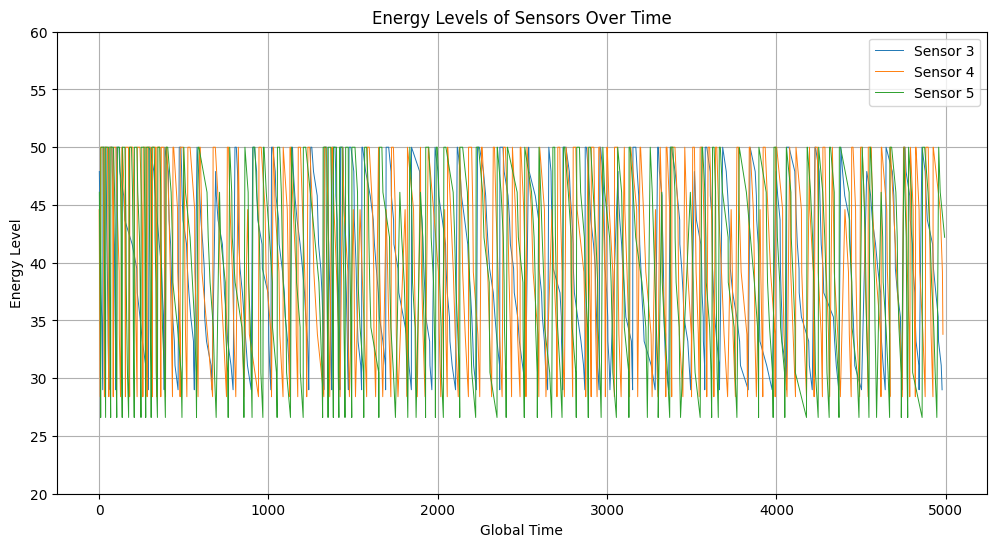

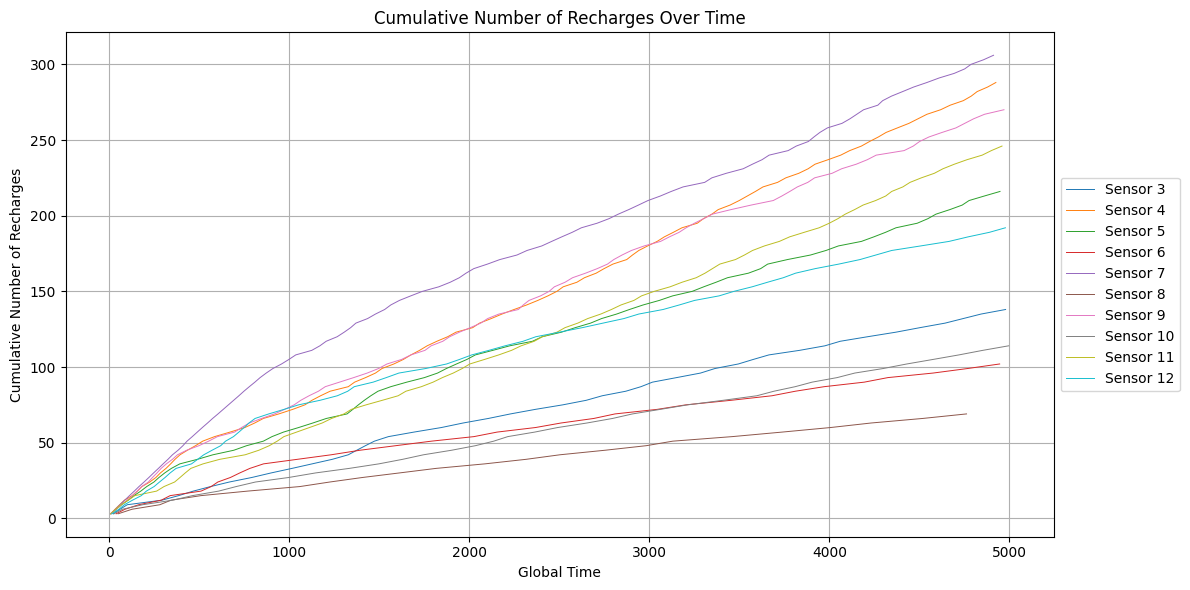

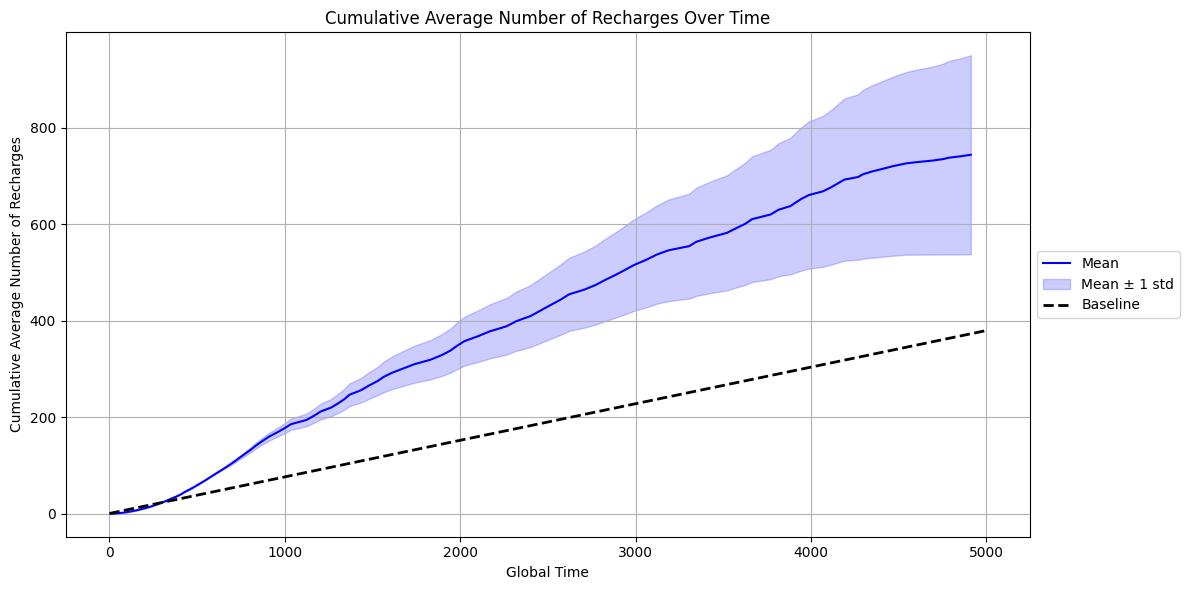

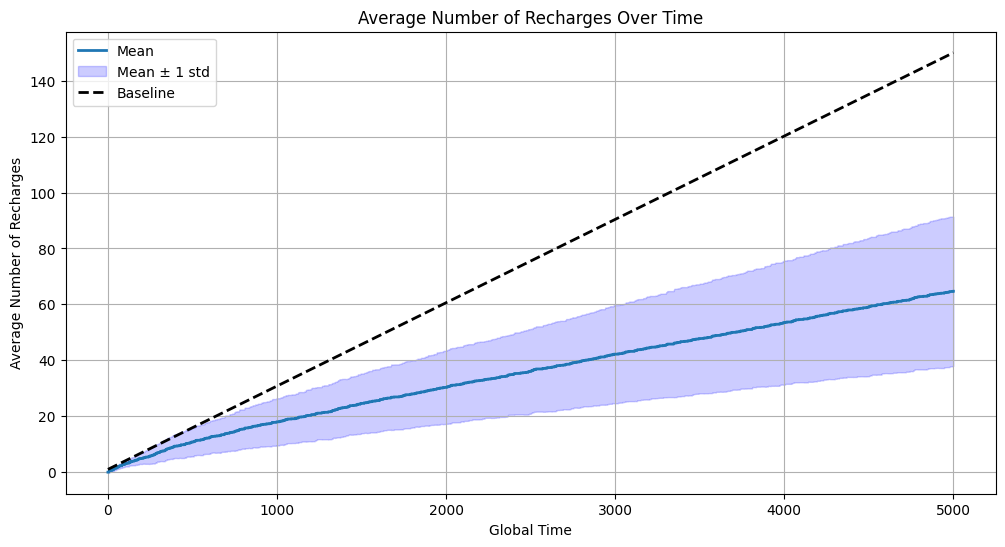

In [ ]:

# Example usage
if __name__ == "__main__":
    # Load your sensor data

    n = 10000  # Replace this with any desired number of rows

    # Load data for debugging (use only the first n rows)
    # towerData_2 = pd.read_csv("post_data/tower2Data_processed.csv").head(n)
    towerData_3 = pd.read_csv("post_data/tower3Data_processed.csv").head(n)
    towerData_4 = pd.read_csv("post_data/tower4Data_processed.csv").head(n)
    towerData_5 = pd.read_csv("post_data/tower5Data_processed.csv").head(n)
    towerData_6 = pd.read_csv("post_data/tower6Data_processed.csv").head(n)
    towerData_7 = pd.read_csv("post_data/tower7Data_processed.csv").head(n)
    towerData_8 = pd.read_csv("post_data/tower8Data_processed.csv").head(n)
    towerData_9 = pd.read_csv("post_data/tower9Data_processed.csv").head(n)
    towerData_10 = pd.read_csv("post_data/tower10Data_processed.csv").head(n)
    towerData_11 = pd.read_csv("post_data/tower11Data_processed.csv").head(n)
    towerData_12 = pd.read_csv("post_data/tower12Data_processed.csv").head(n)



    # Create a dictionary to store all tower data
    sensor_data = {

        3: towerData_3,
        4: towerData_4,
        5: towerData_5,
        6: towerData_6,
        7: towerData_7,
        8: towerData_8,
        9: towerData_9,
        10: towerData_10,
        11: towerData_11,
        12: towerData_12
    }

    # Initialize environment
    env = WSNEnvironment()

    # Add sensors
    for sensor_id in sensor_data.keys():
        env.add_sensor(sensor_id, initial_energy=50, recharge_threshold=30, recharge_time=20)

    # Initialize the RL scheduler
    env.initialize_scheduler(state_size=4, action_size=2, num_levels=2)

    # Run simulation
    env.simulate(sensor_data, n=5000)

    # Plot results
    env.plot_energy_levels()
    env.plot_cumulative_recharges()
    env.plot_single_cumulative_recharges()
    # env.plot_cumulative_recharges_()
    # env.plot_cumulative_recharges_with_mean_and_baseline()
    env.plot_average_recharges()
    # env.plot_cumulative_recharges_with_mean_and_baseline()
    # env.plot_frequency_distance()
    # env.plot_latest_timestamps()

## DQN

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, defaultdict
import random
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

class SensorNode:
    def __init__(self, sensor_id, buffer_size=100, flush_size=10, initial_energy=100, recharge_threshold=20, recharge_time=3):
        # Basic sensor properties
        self.sensor_id = sensor_id
        self.initial_energy = initial_energy
        self.energy = initial_energy
        self.recharge_threshold = recharge_threshold
        self.recharge_time = recharge_time
        self.recharge_count = 0
        self.recharge_end_time = 0

        # Buffer management
        self.buffer = deque(maxlen=buffer_size)
        self.flush_size = flush_size
        self.flush_log = []

        # Monitoring variables
        self.energy_over_time = []
        self.recharge_over_time = []
        self.latest_timestamp_over_time = []
        ###
        self.node_energy = node_energy_
        # RL-specific properties
        self.previous_frequency = 1

    def add_data(self, row, global_time):
        if global_time < self.recharge_end_time:
            self.energy_over_time.append((global_time, self.energy))
            if self.buffer:
                self.latest_timestamp_over_time.append((global_time, self.buffer[-1]['Timestamp']))
            return

        # self.energy -= 1
        self.energy -= self.node_energy[self.sensor_id]
        self.energy_over_time.append((global_time, self.energy))

        self.buffer.append(row)
        self.latest_timestamp_over_time.append((global_time, row['Timestamp']))

        if self.energy < self.recharge_threshold:
            self.recharge(global_time)

        if len(self.buffer) == self.buffer.maxlen:
            self.flush_data()

    def flush_data(self):
        flushed_values = [self.buffer.popleft() for _ in range(self.flush_size)]
        self.flush_log.append(flushed_values)

    def recharge(self, global_time):
        self.recharge_count += 1
        self.energy = self.initial_energy
        self.recharge_end_time = global_time + self.recharge_time
        self.recharge_over_time.append((global_time, self.recharge_count))

    def update_energy(self, global_time):
        if global_time >= self.recharge_end_time:
            self.energy -= self.node_energy[self.sensor_id]
            if self.energy < self.recharge_threshold:
                self.recharge(global_time)

    # def calculate_energy(d, d_0=0.01, K=10, a=1, E_0=0):
    #     return E_0 + K / (1 + np.exp(-a * (d - d_0)))
    # cluster_head = "towerData_1"
    # distances_to_cluster_head = distance_matrix[cluster_head].astype(float)
    # energy_consumption = distances_to_cluster_head.apply(calculate_energy)

class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 8)  # Hidden layer with 8 neurons
        self.fc2 = nn.Linear(8, action_size)  # Output layer with Q-values for each action

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Updated RLScheduler for DQN
class RLScheduler:
    def __init__(self, num_sensors, state_size, action_size, num_levels):
        self.num_sensors = num_sensors
        self.state_size = state_size
        self.action_size = action_size
        self.num_levels = num_levels

        # Initialize Q-network and target network
        self.q_network = QNetwork(state_size, action_size)
        self.target_network = QNetwork(state_size, action_size)
        self.target_network.load_state_dict(self.q_network.state_dict())  # Sync networks
        self.target_network.eval()

        # Replay buffer
        self.replay_buffer = deque(maxlen=1000)

        # Optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=0.001)

        # Hyperparameters
        self.gamma = 0.9  # Discount factor
        self.batch_size = 32
        self.update_frequency = 10  # Update target network every 10 steps

        self.steps = 0  # Track training steps

    def one_hot_encode(self, state):
        """
        One-hot encode the state. Clamp the state to ensure it is within the valid range.
        """
        state = max(0, min(state, self.state_size - 1))  # Clamp state to valid range
        one_hot = np.zeros(self.state_size)
        one_hot[state] = 1
        return one_hot

    def get_action(self, state, training=True, epsilon=0.1):
        """
        Epsilon-greedy action selection for exploration and exploitation.
        """
        if training and np.random.rand() < epsilon:
            return np.random.choice(self.action_size)  # Exploration
        else:
            state_tensor = torch.FloatTensor([self.one_hot_encode(state)])  # One-hot encode state
            q_values = self.q_network(state_tensor).detach().numpy()
            return np.argmax(q_values)  # Exploitation

    def store_experience(self, state, action, reward, next_state):
        """
        Store experience in the replay buffer.
        """
        self.replay_buffer.append((state, action, reward, next_state))

    def train(self):
        """
        Train the Q-network using experiences from the replay buffer.
        """
        if len(self.replay_buffer) < self.batch_size:
            return  # Not enough samples to train

        # Sample a mini-batch
        batch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states = zip(*batch)

        # Convert to tensors
        states = torch.FloatTensor([self.one_hot_encode(s) for s in states])
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor([self.one_hot_encode(s) for s in next_states])

        # Compute target Q-values
        next_q_values = self.target_network(next_states).max(1)[0]
        targets = rewards + self.gamma * next_q_values

        # Compute current Q-values
        q_values = self.q_network(states).gather(1, actions.view(-1, 1)).squeeze()

        # Compute loss
        loss = nn.MSELoss()(q_values, targets)

        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network periodically
        self.steps += 1
        if self.steps % self.update_frequency == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

    def update_q_value(self, state, action, reward, next_state):
        """
        Add experience to the replay buffer and train the network.
        """
        self.store_experience(state, action, reward, next_state)
        self.train()


class WSNEnvironment:
    def __init__(self):
        self.sensors = {}
        self.global_time = 0
        self.scheduler = None
        self.discrete_threshold = [0.25, 0.50002455, 0.75]

    def add_sensor(self, sensor_id, buffer_size=100, flush_size=10, initial_energy=100, recharge_threshold=20, recharge_time=3):
        self.sensors[sensor_id] = SensorNode(sensor_id, buffer_size, flush_size, initial_energy, recharge_threshold, recharge_time)

    def initialize_scheduler(self, state_size, action_size, num_levels):


        self.scheduler = RLScheduler(
            num_sensors=len(self.sensors),
            state_size=state_size,
            action_size=action_size,
            num_levels=num_levels
        )

        print("  Scheduler created successfully")


    def calculate_reward(self, f_i, discrete_similarity, lambda_param=0.01):
        reward = -1 * (discrete_similarity)
        reward += (-(f_i) * 0.01)

        return reward

    def calculate_similarity(self, sensor_data, step):
        """
        Calculate similarities between sensors at a given time step

        Args:
            sensor_data (dict): Dictionary of sensor dataframes
            step (int): Current time step

        Returns:
            dict: Similarities between sensor pairs
        """
        # Round temperature values to 3 decimal places
        rounded_values = {
            sensor_id: round(df.loc[step, "Temperature_2m"], 3)
            for sensor_id, df in sensor_data.items()
        }

        # Compute similarities
        similarities = {}
        sensor_ids = list(rounded_values.keys())

        for i in range(len(sensor_ids)):
            for j in range(i + 1, len(sensor_ids)):
                sensor_i = sensor_ids[i]
                sensor_j = sensor_ids[j]

                # Simple dot product similarity
                value_i = rounded_values[sensor_i]
                value_j = rounded_values[sensor_j]

                # Compute dot product similarity
                similarity = abs(value_i * value_j) / (abs(value_i) + abs(value_j) + 1e-10)

                similarities[(sensor_i, sensor_j)] = similarity

        return similarities




    def calculate_similarity_score(self, sensor_id, similarites, alpha=1, beta=1):
        similarity = 0.0
        n = len(similarites)
        for (i, j), jaccard in similarites.items():
            if sensor_id == i or sensor_id == j:
                similarity += alpha * jaccard
        aggregated_similarity = similarity / max(n, 1)
        buffer_margin=0.01
        # Define robust min and max (static or dynamic)
        current_min = 0.0227  # Replace with observed min_similarity or predefined value
        current_max = 0.0826  # Replace with observed max_similarity or predefined value
        min_similarity = current_min - buffer_margin
        max_similarity = current_max + buffer_margin

        # Clamp values to handle outliers
        clamped_similarity = max(min(aggregated_similarity, max_similarity), min_similarity)

        # Normalize to range [0, 1]
        normalized_similarity = (clamped_similarity - min_similarity) / (max_similarity - min_similarity)

        return normalized_similarity
    def get_similarity_level(self, similarity_value):
        """
        Map a single similarity value to its corresponding level based on class variable discrete_threshold.

        Args:
            similarity_value (float): The similarity value to map to a level.

        Returns:
            int: The level corresponding to the similarity value.
        """
        for i, threshold in enumerate(self.discrete_threshold):
            if similarity_value < threshold:
                return i + 1
        return len(self.discrete_threshold) + 1

    def determine_usage(self, sensor_data, n_steps, alpha=0.1, beta=0.1, lambda_param=0.1, training=True):
        """
        Determine sensor transmission usage with comprehensive debug info

        Args:
            sensor_data (dict): Dictionary of sensor dataframes
            n_steps (int): Number of time steps to simulate
            alpha (float): Weight for unique data reward
            beta (float): Weight for similarity penalty
            lambda_param (float): Energy conservation parameter
            training (bool): Whether in training mode

        Returns:
            list: Usage array with transmission decisions for each sensor at each time step
        """
        # Initialize usage array with zeros
        usage_array = [[0 for _ in range(n_steps)] for _ in range(len(sensor_data))]
        sensor_ids = list(sensor_data.keys())


        similarity_stats = []
        jaccard_stats = []
        level_counts = {level: 0 for level in range(1, len(self.discrete_threshold) + 2)}
        sensor_level_counts = {
        sensor_id: {level: 0 for level in range(1, len(self.discrete_threshold) + 2)}
        for sensor_id in sensor_data.keys()
        }



        for step in range(n_steps):

            jaccard_similarities = self.calculate_similarity(sensor_data, step)
            # print("Raw Similarity: ", jaccard_similarities)
            jaccard_stats.extend(jaccard_similarities.values())

            for sensor_id in sensor_data.keys():
                similarity = self.calculate_similarity_score(sensor_id, jaccard_similarities, alpha, beta)
                level = self.get_similarity_level(similarity)
                #######PRINT STATEMETS#########
                level_counts[level] += 1
                sensor_level_counts[sensor_id][level] += 1
                similarity_stats.append(similarity)
                #######PRINT STATEMETS#########
                state = level

                action = self.scheduler.get_action(state, training=training)
                # reward = -1 * (level)
                # reward += (-(action) * 0.01)
                reward = self.calculate_reward(action, level)



                # if sensor_id == 4:
                #     reward -= 10
                next_state = state
                self.scheduler.update_q_value(state, action, reward, next_state)
                # Update usage array based on action (e.g., action 1 = transmit)
                usage_array[list(sensor_data.keys()).index(sensor_id)][step] = action


        # Convert to a NumPy array for easier analysis
        similarity_stats = np.array(similarity_stats)
        jaccard_stats = np.array(jaccard_stats)

        # Calculate statistics across steps for similarity scores
        mean_similarity = np.mean(similarity_stats)
        std_similarity = np.std(similarity_stats)
        min_similarity = np.min(similarity_stats)
        max_similarity = np.max(similarity_stats)
        n_levels = 4
        bins = np.linspace(min_similarity, max_similarity, n_levels + 1)
        discretized_levels = np.digitize(similarity_stats, bins, right=False)

        # # Count the number of values in each level
        # level_counts = {level: np.sum(discretized_levels == level) for level in range(1, n_levels + 1)}

        # Print the counts
        # print(f"\nDiscretized Similarity Levels (n_levels={n_levels}):")
        # for level, count in level_counts.items():
        #     print(f"  Level {level}: {count} values")
        print(f"Discretization Thresholds (n_levels={n_levels}): {bins}")
        print(f"\nDiscretized Similarity Levels (based on {len(self.discrete_threshold)} thresholds):")
        for level, count in level_counts.items():
            print(f"  Level {level}: {count} values")
        # print(f"\nSensor-Specific Level Counts:")
        # for sensor_id, counts in sensor_level_counts.items():
        #     print(f"  Sensor {sensor_id}:")
        #     for level, count in counts.items():
        #         print(f"    Level {level}: {count} times")

        # Print overall statistics for similarity scores
        print("\nOverall Similarity Statistics Across Steps:")
        print(f"  Mean Similarity: {mean_similarity:.4f}")
        print(f"  Std Deviation: {std_similarity:.4f}")
        print(f"  Min Similarity: {min_similarity:.4f}")
        print(f"  Max Similarity: {max_similarity:.4f}")

        # Calculate aggregated statistics for Jaccard similarities across steps
        mean_jaccard = np.mean(jaccard_stats)
        std_jaccard = np.std(jaccard_stats)
        min_jaccard = np.min(jaccard_stats)
        max_jaccard = np.max(jaccard_stats)

        # Print overall statistics for Jaccard similarities
        print("\nOverall Jaccard Similarity Statistics Across Steps:")
        print(f"  Mean Jaccard Similarity: {mean_jaccard:.4f}")
        print(f"  Std Deviation: {std_jaccard:.4f}")
        print(f"  Min Jaccard Similarity: {min_jaccard:.4f}")
        print(f"  Max Jaccard Similarity: {max_jaccard:.4f}")
        print(f"Total 0's: {sum(row.count(0) for row in usage_array)}, Total 1's: {sum(row.count(1) for row in usage_array)}")
        high_frequency = sum(row.count(1) for row in usage_array)
        percent_high_frequency = high_frequency / (high_frequency + sum(row.count(0) for row in usage_array)) * 100
        print("Percentage of actions in High Frequency: ", percent_high_frequency)
        return usage_array

    def simulate(self, sensor_data, n):
        num_rows = min(len(df) for df in sensor_data.values())
        iterations = min(n, num_rows)

        # Determine the usage array using RL
        usage_array = self.determine_usage(sensor_data, iterations)

        # Get total unique values across all sensors
        total_values = set()
        transmitted_values = set()

        # Track data points
        for row_index in tqdm(range(iterations), desc="Simulating data collection", unit="step"):
            for sensor_id, df in sensor_data.items():
                # Round to first decimal place and add to total values
                value = round(df.iloc[row_index]['Temperature_2m'], 3)
                total_values.add(value)

                # If transmission is allowed, add to transmitted values
                sensor_index = list(sensor_data.keys()).index(sensor_id)
                if usage_array[sensor_index][row_index] == 1:
                    transmitted_values.add(value)
                    row_data = df.iloc[row_index]
                    self.add_data(sensor_id, row_data)
            self.global_time += 1

        # Calculate transmission counts for each sensor
        transmission_counts = {
            sensor_id: np.sum(usage_array[list(sensor_data.keys()).index(sensor_id)])
            for sensor_id in sensor_data.keys()
        }

        # Print transmission statistics
        print("\nSensor Transmission Counts:")
        for sensor_id, count in transmission_counts.items():
            print(f"Sensor {sensor_id}: {count} transmissions")

        # Print data loss statistics
        total_unique = len(total_values)
        transmitted_unique = len(transmitted_values)
        lost_unique = total_unique - transmitted_unique

        print(f"\nData Loss Analysis:")
        print(f"Total unique temperature readings: {total_unique}")
        print(f"Transmitted unique temperature readings: {transmitted_unique}")
        print(f"Lost unique temperature readings: {lost_unique}")
        print(f"Percentage of unique readings preserved: {(transmitted_unique/total_unique)*100:.2f}%")
        print(f"Percentage of unique readings lost: {(lost_unique/total_unique)*100:.2f}%")


    def add_data(self, sensor_id, row):
        if sensor_id not in self.sensors:
            raise ValueError(f"Sensor ID {sensor_id} is not valid.")
        self.sensors[sensor_id].add_data(row, self.global_time)

    def plot_energy_levels(self):
        plt.figure(figsize=(12, 6))
        i = 0
        for sensor_id, sensor in (self.sensors.items()):
            if i > 2:
                break
            time, energy = zip(*sensor.energy_over_time)
            plt.plot(time, energy, marker='o', markersize=0, linestyle='-', linewidth=0.7, label=f'Sensor {sensor_id}')
            i += 1
        plt.xlabel('Global Time')
        plt.ylabel('Energy Level')
        plt.title('Energy Levels of Sensors Over Time')
        plt.legend()
        plt.grid(True)
        plt.ylim(20, 60)
        # plt.xlim(100, 400)
        plt.show()

    def plot_cumulative_recharges(self):
        plt.figure(figsize=(12, 6))
        ctr = 0
        # Plot actual cumulative recharges for each sensor
        for sensor_id, sensor in self.sensors.items():
            time, recharge_count = zip(*sensor.recharge_over_time) if sensor.recharge_over_time else ([], [])
            ctr+=1
            print(len(sensor.recharge_over_time))
            plt.plot(time, recharge_count, marker='o', markersize=0, linestyle='-', linewidth=0.7, label=f'Sensor {sensor_id}')
        # print("l rcovt", len(sensor.re))
        print("CTR", ctr)
        # Plot labels and legend
        plt.xlabel('Global Time')
        plt.ylabel('Cumulative Number of Recharges')
        plt.title('Cumulative Number of Recharges Over Time')

        # Adjust the legend to be on the side
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        plt.grid(True)
        plt.tight_layout()  # Ensure everything fits without overlapping
        plt.show()

    def plot_single_cumulative_recharges(self):
            plt.figure(figsize=(12, 6))

            # Get the cumulative recharges for all sensors
            all_recharges = []
            max_time = 0
            global_time = None  # To capture the global time for alignment
            for sensor in self.sensors.values():
                time, recharge_count = zip(*sensor.recharge_over_time) if sensor.recharge_over_time else ([], [])
                all_recharges.append(recharge_count)
                if global_time is None or len(time) > len(global_time):
                    global_time = time
                max_time = max(max_time, len(recharge_count))

            # Align all recharge sequences to the same length by padding with 0s
            aligned_recharges = []
            for recharge in all_recharges:
                aligned_recharges.append(np.pad(recharge, (0, max_time - len(recharge)), constant_values=0))
            aligned_recharges = np.array(aligned_recharges, dtype=float)
            aligned_recharges = aligned_recharges/10
            # Calculate the mean and standard deviation at each time point
            mean_recharges = np.mean(aligned_recharges, axis=0)  # Mean of values across sensors
            std_recharges = np.std(aligned_recharges, axis=0)   # Std deviation of values across sensors

            # Calculate the cumulative sum for mean and std deviation
            cumulative_mean_recharges = np.cumsum(mean_recharges)
            cumulative_std_recharges = np.cumsum(std_recharges) / np.sqrt(len(self.sensors))  # Adjust std for averaging

            # Plot the mean +/- 1 standard deviation
            plt.plot(global_time, cumulative_mean_recharges, color='blue', label='Mean')
            plt.fill_between(
                global_time,
                cumulative_mean_recharges - cumulative_std_recharges,
                cumulative_mean_recharges + cumulative_std_recharges,
                color='blue',
                alpha=0.2,
                label='Mean ± 1 std'
            )
            baseline_time = range(self.global_time + 1)  # Time steps from 0 to global time
            baseline_recharges = [1 + (t * (300 - 1) / self.global_time) for t in baseline_time]
            plt.plot(
                baseline_time,
                baseline_recharges,
                linestyle='--',
                linewidth=2,
                color='black',
                label='Baseline'
            )

            # Plot labels and legend
            plt.xlabel('Global Time')
            plt.ylabel('Cumulative Average Number of Recharges')
            plt.title('Cumulative Average Number of Recharges Over Time')
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    def plot_average_recharges(self):
        plt.figure(figsize=(12, 6))
        average_recharges_over_time = []
        max_time = self.global_time
        for time in range(max_time + 1):
            total_recharges = 0
            for sensor in self.sensors.values():
                recharge_count = sum(t <= time for t, _ in sensor.recharge_over_time)
                total_recharges += recharge_count
            average_recharges = total_recharges / len(self.sensors)
            average_recharges_over_time.append(average_recharges)
        time_steps = range(max_time + 1)
        plt.plot(time_steps, average_recharges_over_time, linestyle='-', linewidth=2)
        plt.xlabel('Global Time')
        plt.ylabel('Average Number of Recharges')
        plt.title('Average Number of Recharges Over Time')
        plt.grid(True)
        plt.show()



def sigmoid(x):
    return 1 / (1 + np.exp(-x))


  Scheduler created successfully
Discretization Thresholds (n_levels=4): [0.   0.25 0.5  0.75 1.  ]

Discretized Similarity Levels (based on 3 thresholds):
  Level 1: 8100 values
  Level 2: 14195 values
  Level 3: 21515 values
  Level 4: 6190 values

Overall Similarity Statistics Across Steps:
  Mean Similarity: 0.4936
  Std Deviation: 0.2083
  Min Similarity: 0.0000
  Max Similarity: 1.0000

Overall Jaccard Similarity Statistics Across Steps:
  Mean Jaccard Similarity: 2.6022
  Std Deviation: 1.2718
  Min Jaccard Similarity: 0.0227
  Max Jaccard Similarity: 6.7227
Total 0's: 34102, Total 1's: 15898
Percentage of actions in High Frequency:  31.796000000000003


Simulating data collection: 100%|██████████| 5000/5000 [00:00<00:00, 5093.44step/s]



Sensor Transmission Counts:
Sensor 3: 1368 transmissions
Sensor 4: 1557 transmissions
Sensor 5: 1601 transmissions
Sensor 6: 1654 transmissions
Sensor 7: 1735 transmissions
Sensor 8: 1670 transmissions
Sensor 9: 1624 transmissions
Sensor 10: 1618 transmissions
Sensor 11: 1528 transmissions
Sensor 12: 1543 transmissions

Data Loss Analysis:
Total unique temperature readings: 1173
Transmitted unique temperature readings: 1035
Lost unique temperature readings: 138
Percentage of unique readings preserved: 88.24%
Percentage of unique readings lost: 11.76%


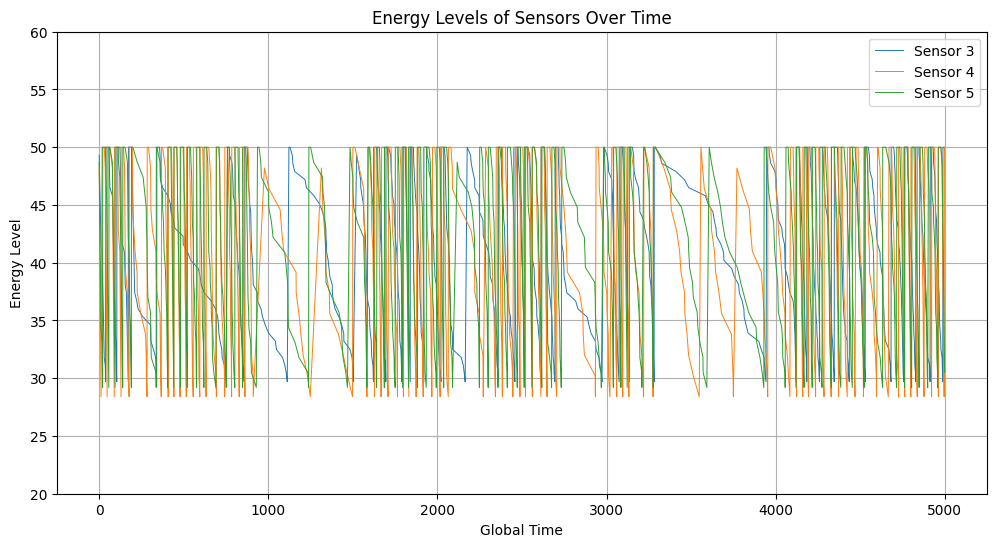

36
75
64
31
81
22
84
37
71
48
CTR 10


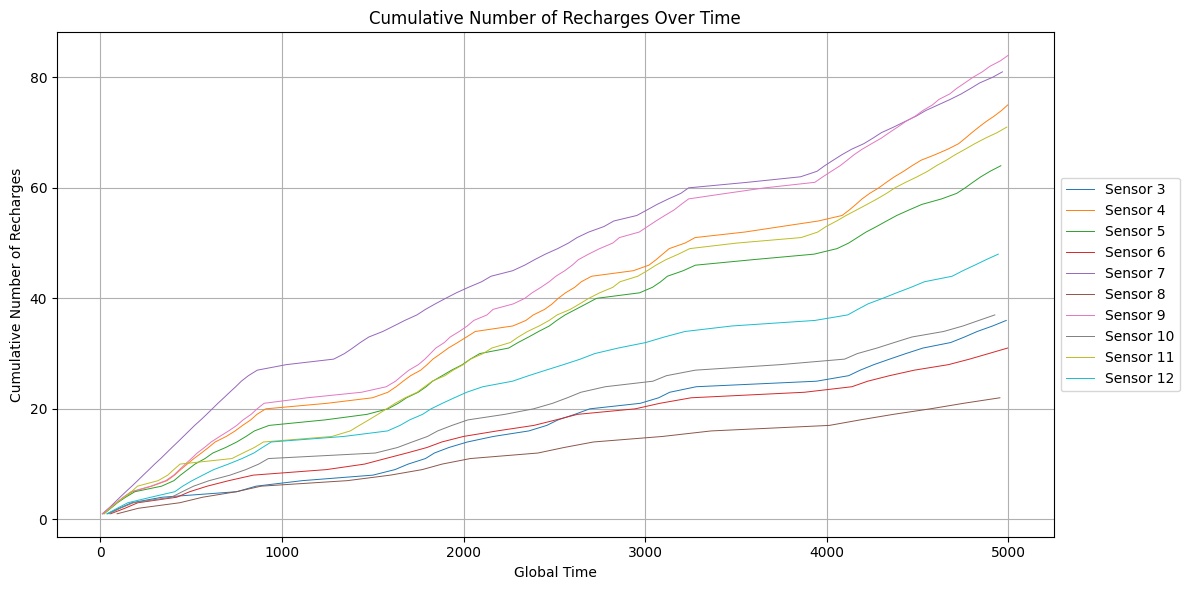

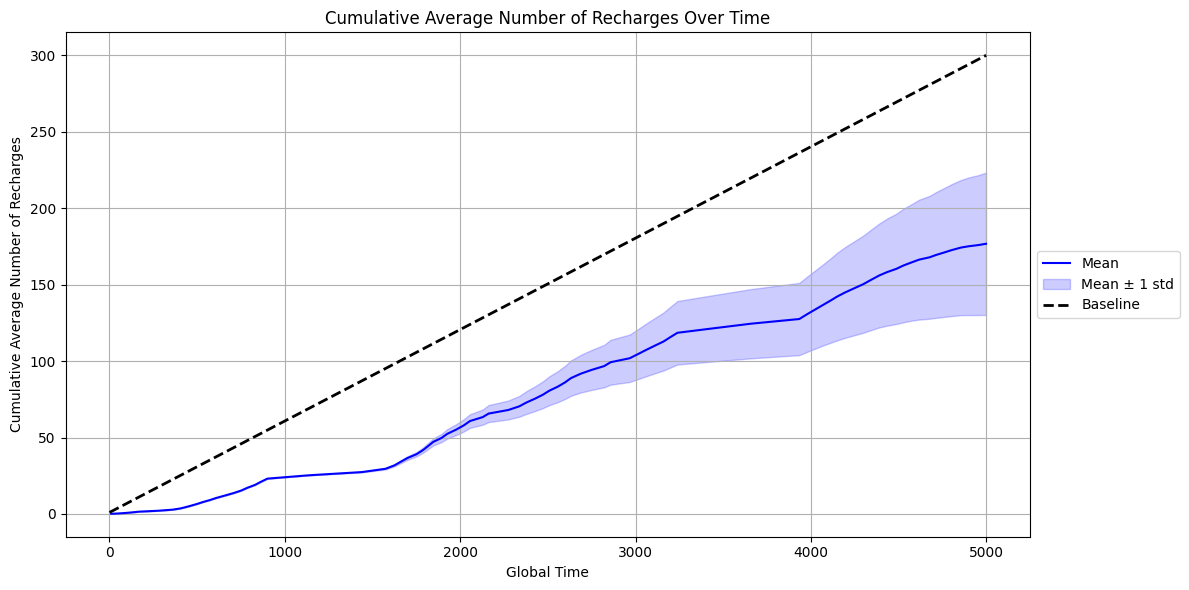

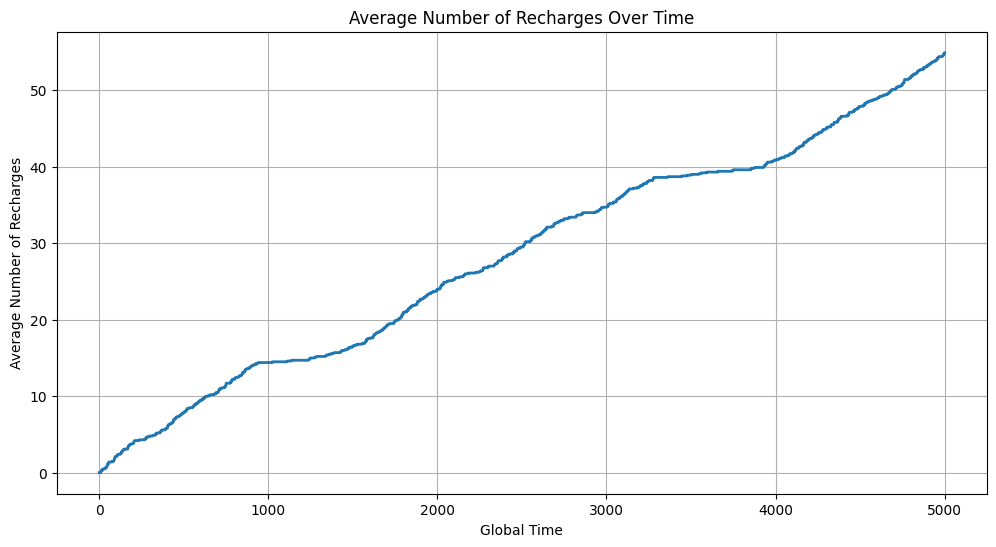

In [ ]:

# Example usage
if __name__ == "__main__":
    # Load your sensor data

    n = 10000  # Replace this with any desired number of rows

    # Load data for debugging (use only the first n rows)
    # towerData_2 = pd.read_csv("post_data/tower2Data_processed.csv").head(n)
    towerData_3 = pd.read_csv("post_data/tower3Data_processed.csv").head(n)
    towerData_4 = pd.read_csv("post_data/tower4Data_processed.csv").head(n)
    towerData_5 = pd.read_csv("post_data/tower5Data_processed.csv").head(n)
    towerData_6 = pd.read_csv("post_data/tower6Data_processed.csv").head(n)
    towerData_7 = pd.read_csv("post_data/tower7Data_processed.csv").head(n)
    towerData_8 = pd.read_csv("post_data/tower8Data_processed.csv").head(n)
    towerData_9 = pd.read_csv("post_data/tower9Data_processed.csv").head(n)
    towerData_10 = pd.read_csv("post_data/tower10Data_processed.csv").head(n)
    towerData_11 = pd.read_csv("post_data/tower11Data_processed.csv").head(n)
    towerData_12 = pd.read_csv("post_data/tower12Data_processed.csv").head(n)



    # Create a dictionary to store all tower data
    sensor_data = {

        3: towerData_3,
        4: towerData_4,
        5: towerData_5,
        6: towerData_6,
        7: towerData_7,
        8: towerData_8,
        9: towerData_9,
        10: towerData_10,
        11: towerData_11,
        12: towerData_12
    }

    # Initialize environment
    env = WSNEnvironment()

    # Add sensors
    for sensor_id in sensor_data.keys():
        env.add_sensor(sensor_id, initial_energy=50, recharge_threshold=30, recharge_time=20)

    # Initialize the RL scheduler
    env.initialize_scheduler(state_size=4, action_size=2, num_levels=2)

    # Run simulation
    env.simulate(sensor_data, n=5000)

    # Plot results
    env.plot_energy_levels()
    env.plot_cumulative_recharges()
    env.plot_single_cumulative_recharges()
    env.plot_average_recharges()
    # env.plot_frequency_distance()
    # env.plot_latest_timestamps()

## Adding Distance Parameter

#### New Min Max Normalization.

In [ ]:
import pandas as pd

# Specify the file name
file_name = "Updated_Tower_Distance_Matrix_with_Renamed_Towers.csv"

# Read the dataset
tower_distances = pd.read_csv(file_name)

# Define the base tower and the arbitrary value for z-score calculation
base_tower = "towerData_3"
arbitrary_value = 0.1  # Replace with your desired arbitrary value

# Extract distances of all other towers from the base tower (towerData_3)
tower_range = [f"towerData_{i}" for i in range(3, 13)]
distances_from_base = tower_distances[tower_range][tower_distances['Unnamed: 0'] == base_tower].iloc[0]
print(distances_from_base)

# Compute standard deviation of the distances
std_dev = distances_from_base.std()

# Calculate the modified z-scores
z_scores = (distances_from_base - arbitrary_value) / std_dev
z_scores = (z_scores)

# Rename dictionary keys to just the numbers (3, 4, ..., 13)
z_scores_dict = {int(tower.split('_')[1]): z for tower, z in z_scores.items()}

# Calculate the second dictionary: min-max normalization
min_z_score = min(z_scores_dict.values())
max_z_score = max(z_scores_dict.values())
normalized_z_scores_dict = {
    key: (z - min_z_score) / (max_z_score - min_z_score) for key, z in z_scores_dict.items()
}

# Output the results
print("Z-scores with tower numbers as keys:")
print(z_scores_dict)

print("\nNormalized Z-scores (min-max normalization):")
print(normalized_z_scores_dict)


towerData_3     0.000000
towerData_4     0.620926
towerData_5     0.161633
towerData_6     0.477207
towerData_7     0.693670
towerData_8     0.614248
towerData_9     0.502256
towerData_10    0.489898
towerData_11    0.594189
towerData_12    0.596691
Name: 2, dtype: float64
Z-scores with tower numbers as keys:
{3: -0.4510849004036029, 4: 2.3498167735018107, 5: 0.2780177240560619, 6: 1.7015232009966659, 7: 2.6779567174204137, 8: 2.319695772343577, 9: 1.8145156045637052, 10: 1.7587707324312047, 11: 2.22921267582546, 12: 2.240497270766893}

Normalized Z-scores (min-max normalization):
{3: 0.0, 4: 0.8951308470780914, 5: 0.23301148195232183, 6: 0.6879448611799627, 7: 1.0, 8: 0.8855045765335723, 9: 0.7240557274987097, 10: 0.7062404092827551, 11: 0.8565873847638316, 12: 0.8601937909161665}


#### DQN setup function

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, defaultdict
import random
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

class SensorNode:
    def __init__(self, sensor_id, buffer_size=100, flush_size=10, initial_energy=100, recharge_threshold=20, recharge_time=3):
        # Basic sensor properties
        self.sensor_id = sensor_id
        self.initial_energy = initial_energy
        self.energy = initial_energy
        self.recharge_threshold = recharge_threshold
        self.recharge_time = recharge_time
        self.recharge_count = 0
        self.recharge_end_time = 0

        # Buffer management
        self.buffer = deque(maxlen=buffer_size)
        self.flush_size = flush_size
        self.flush_log = []

        # Monitoring variables
        self.energy_over_time = []
        self.recharge_over_time = []
        self.latest_timestamp_over_time = []
        ###
        self.node_energy = node_energy_
        # RL-specific properties
        self.previous_frequency = 1

    def add_data(self, row, global_time):
        if global_time < self.recharge_end_time:
            self.energy_over_time.append((global_time, self.energy))
            if self.buffer:
                self.latest_timestamp_over_time.append((global_time, self.buffer[-1]['Timestamp']))
            return

        # self.energy -= 1
        self.energy -= self.node_energy[self.sensor_id]
        self.energy_over_time.append((global_time, self.energy))

        self.buffer.append(row)
        self.latest_timestamp_over_time.append((global_time, row['Timestamp']))

        if self.energy < self.recharge_threshold:
            self.recharge(global_time)

        if len(self.buffer) == self.buffer.maxlen:
            self.flush_data()

    def flush_data(self):
        flushed_values = [self.buffer.popleft() for _ in range(self.flush_size)]
        self.flush_log.append(flushed_values)

    def recharge(self, global_time):
        self.recharge_count += 1
        self.energy = self.initial_energy
        self.recharge_end_time = global_time + self.recharge_time
        self.recharge_over_time.append((global_time, self.recharge_count))

    def update_energy(self, global_time):
        if global_time >= self.recharge_end_time:
            self.energy -= self.node_energy[self.sensor_id]
            if self.energy < self.recharge_threshold:
                self.recharge(global_time)

    # def calculate_energy(d, d_0=0.01, K=10, a=1, E_0=0):
    #     return E_0 + K / (1 + np.exp(-a * (d - d_0)))
    # cluster_head = "towerData_1"
    # distances_to_cluster_head = distance_matrix[cluster_head].astype(float)
    # energy_consumption = distances_to_cluster_head.apply(calculate_energy)

class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 8)  # Hidden layer with 8 neurons
        self.fc2 = nn.Linear(8, action_size)  # Output layer with Q-values for each action

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Updated RLScheduler for DQN
class RLScheduler:
    def __init__(self, num_sensors, state_size, action_size, num_levels):
        self.num_sensors = num_sensors
        self.state_size = state_size
        self.action_size = action_size
        self.num_levels = num_levels

        # Initialize Q-network and target network
        self.q_network = QNetwork(state_size, action_size)
        self.target_network = QNetwork(state_size, action_size)
        self.target_network.load_state_dict(self.q_network.state_dict())  # Sync networks
        self.target_network.eval()

        # Replay buffer
        self.replay_buffer = deque(maxlen=1000)

        # Optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=0.001)

        # Hyperparameters
        self.gamma = 0.9  # Discount factor
        self.batch_size = 32
        self.update_frequency = 10  # Update target network every 10 steps

        self.steps = 0  # Track training steps

    def one_hot_encode(self, state):
        """
        One-hot encode the state. Clamp the state to ensure it is within the valid range.
        """
        state = max(0, min(state, self.state_size - 1))  # Clamp state to valid range
        one_hot = np.zeros(self.state_size)
        one_hot[state] = 1
        return one_hot

    def get_action(self, state, training=True, epsilon=0.1):
        """
        Epsilon-greedy action selection for exploration and exploitation.
        """
        if training and np.random.rand() < epsilon:
            return np.random.choice(self.action_size)  # Exploration
        else:
            state_tensor = torch.FloatTensor([self.one_hot_encode(state)])  # One-hot encode state
            q_values = self.q_network(state_tensor).detach().numpy()
            return np.argmax(q_values)  # Exploitation

    def store_experience(self, state, action, reward, next_state):
        """
        Store experience in the replay buffer.
        """
        self.replay_buffer.append((state, action, reward, next_state))

    def train(self):
        """
        Train the Q-network using experiences from the replay buffer.
        """
        if len(self.replay_buffer) < self.batch_size:
            return  # Not enough samples to train

        # Sample a mini-batch
        batch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states = zip(*batch)

        # Convert to tensors
        states = torch.FloatTensor([self.one_hot_encode(s) for s in states])
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor([self.one_hot_encode(s) for s in next_states])

        # Compute target Q-values
        next_q_values = self.target_network(next_states).max(1)[0]
        targets = rewards + self.gamma * next_q_values

        # Compute current Q-values
        q_values = self.q_network(states).gather(1, actions.view(-1, 1)).squeeze()

        # Compute loss
        loss = nn.MSELoss()(q_values, targets)

        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network periodically
        self.steps += 1
        if self.steps % self.update_frequency == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

    def update_q_value(self, state, action, reward, next_state):
        """
        Add experience to the replay buffer and train the network.
        """
        self.store_experience(state, action, reward, next_state)
        self.train()


class WSNEnvironment:
    def __init__(self):
        self.sensors = {}
        self.global_time = 0
        self.scheduler = None
        self.discrete_threshold = [0.25, 0.50002455, 0.75]

    def add_sensor(self, sensor_id, buffer_size=100, flush_size=10, initial_energy=100, recharge_threshold=20, recharge_time=3):
        self.sensors[sensor_id] = SensorNode(sensor_id, buffer_size, flush_size, initial_energy, recharge_threshold, recharge_time)

    def initialize_scheduler(self, state_size, action_size, num_levels):


        self.scheduler = RLScheduler(
            num_sensors=len(self.sensors),
            state_size=state_size,
            action_size=action_size,
            num_levels=num_levels
        )

        print("  Scheduler created successfully")


    def calculate_reward(self,sensor_id, f_i, discrete_similarity, lambda_param=0.01):
        reward = -1 * (discrete_similarity)
        reward += (-(f_i) * 0.01)
        reward += -1 * (normalized_z_scores_dict[sensor_id]) * 0.6
        return reward

    def calculate_similarity(self, sensor_data, step):
        """
        Calculate similarities between sensors at a given time step

        Args:
            sensor_data (dict): Dictionary of sensor dataframes
            step (int): Current time step

        Returns:
            dict: Similarities between sensor pairs
        """
        # Round temperature values to 3 decimal places
        rounded_values = {
            sensor_id: round(df.loc[step, "Temperature_2m"], 3)
            for sensor_id, df in sensor_data.items()
        }

        # Compute similarities
        similarities = {}
        sensor_ids = list(rounded_values.keys())

        for i in range(len(sensor_ids)):
            for j in range(i + 1, len(sensor_ids)):
                sensor_i = sensor_ids[i]
                sensor_j = sensor_ids[j]

                # Simple dot product similarity
                value_i = rounded_values[sensor_i]
                value_j = rounded_values[sensor_j]

                # Compute dot product similarity
                similarity = abs(value_i * value_j) / (abs(value_i) + abs(value_j) + 1e-10)

                similarities[(sensor_i, sensor_j)] = similarity

        return similarities




    def calculate_similarity_score(self, sensor_id, similarites, alpha=1, beta=1):
        similarity = 0.0
        n = len(similarites)
        for (i, j), jaccard in similarites.items():
            if sensor_id == i or sensor_id == j:
                similarity += alpha * jaccard
        aggregated_similarity = similarity / max(n, 1)
        buffer_margin=0.01
        # Define robust min and max (static or dynamic)
        current_min = 0.0227  # Replace with observed min_similarity or predefined value
        current_max = 0.0826  # Replace with observed max_similarity or predefined value
        min_similarity = current_min - buffer_margin
        max_similarity = current_max + buffer_margin

        # Clamp values to handle outliers
        clamped_similarity = max(min(aggregated_similarity, max_similarity), min_similarity)

        # Normalize to range [0, 1]
        normalized_similarity = (clamped_similarity - min_similarity) / (max_similarity - min_similarity)

        return normalized_similarity
    def get_similarity_level(self, similarity_value):
        """
        Map a single similarity value to its corresponding level based on class variable discrete_threshold.

        Args:
            similarity_value (float): The similarity value to map to a level.

        Returns:
            int: The level corresponding to the similarity value.
        """
        for i, threshold in enumerate(self.discrete_threshold):
            if similarity_value < threshold:
                return i + 1
        return len(self.discrete_threshold) + 1

    def determine_usage(self, sensor_data, n_steps, alpha=0.1, beta=0.1, lambda_param=0.1, training=True):
        """
        Determine sensor transmission usage with comprehensive debug info

        Args:
            sensor_data (dict): Dictionary of sensor dataframes
            n_steps (int): Number of time steps to simulate
            alpha (float): Weight for unique data reward
            beta (float): Weight for similarity penalty
            lambda_param (float): Energy conservation parameter
            training (bool): Whether in training mode

        Returns:
            list: Usage array with transmission decisions for each sensor at each time step
        """
        # Initialize usage array with zeros
        usage_array = [[0 for _ in range(n_steps)] for _ in range(len(sensor_data))]
        sensor_ids = list(sensor_data.keys())


        similarity_stats = []
        jaccard_stats = []
        level_counts = {level: 0 for level in range(1, len(self.discrete_threshold) + 2)}
        sensor_level_counts = {
        sensor_id: {level: 0 for level in range(1, len(self.discrete_threshold) + 2)}
        for sensor_id in sensor_data.keys()
        }



        for step in range(n_steps):

            jaccard_similarities = self.calculate_similarity(sensor_data, step)
            # print("Raw Similarity: ", jaccard_similarities)
            jaccard_stats.extend(jaccard_similarities.values())

            for sensor_id in sensor_data.keys():
                similarity = self.calculate_similarity_score(sensor_id, jaccard_similarities, alpha, beta)
                level = self.get_similarity_level(similarity)
                #######PRINT STATEMETS#########
                level_counts[level] += 1
                sensor_level_counts[sensor_id][level] += 1
                similarity_stats.append(similarity)
                #######PRINT STATEMETS#########
                state = level

                action = self.scheduler.get_action(state, training=training)
                # reward = -1 * (level)
                # reward += (-(action) * 0.01)
                reward = self.calculate_reward(sensor_id,action, level)



                # if sensor_id == 4:
                #     reward -= 10
                next_state = state
                self.scheduler.update_q_value(state, action, reward, next_state)
                # Update usage array based on action (e.g., action 1 = transmit)
                usage_array[list(sensor_data.keys()).index(sensor_id)][step] = action


        # Convert to a NumPy array for easier analysis
        similarity_stats = np.array(similarity_stats)
        jaccard_stats = np.array(jaccard_stats)

        # Calculate statistics across steps for similarity scores
        mean_similarity = np.mean(similarity_stats)
        std_similarity = np.std(similarity_stats)
        min_similarity = np.min(similarity_stats)
        max_similarity = np.max(similarity_stats)
        n_levels = 4
        bins = np.linspace(min_similarity, max_similarity, n_levels + 1)
        discretized_levels = np.digitize(similarity_stats, bins, right=False)

        # # Count the number of values in each level
        # level_counts = {level: np.sum(discretized_levels == level) for level in range(1, n_levels + 1)}

        # Print the counts
        # print(f"\nDiscretized Similarity Levels (n_levels={n_levels}):")
        # for level, count in level_counts.items():
        #     print(f"  Level {level}: {count} values")
        print(f"Discretization Thresholds (n_levels={n_levels}): {bins}")
        print(f"\nDiscretized Similarity Levels (based on {len(self.discrete_threshold)} thresholds):")
        for level, count in level_counts.items():
            print(f"  Level {level}: {count} values")
        # print(f"\nSensor-Specific Level Counts:")
        # for sensor_id, counts in sensor_level_counts.items():
        #     print(f"  Sensor {sensor_id}:")
        #     for level, count in counts.items():
        #         print(f"    Level {level}: {count} times")

        # Print overall statistics for similarity scores
        print("\nOverall Similarity Statistics Across Steps:")
        print(f"  Mean Similarity: {mean_similarity:.4f}")
        print(f"  Std Deviation: {std_similarity:.4f}")
        print(f"  Min Similarity: {min_similarity:.4f}")
        print(f"  Max Similarity: {max_similarity:.4f}")

        # Calculate aggregated statistics for Jaccard similarities across steps
        mean_jaccard = np.mean(jaccard_stats)
        std_jaccard = np.std(jaccard_stats)
        min_jaccard = np.min(jaccard_stats)
        max_jaccard = np.max(jaccard_stats)

        # Print overall statistics for Jaccard similarities
        print("\nOverall Jaccard Similarity Statistics Across Steps:")
        print(f"  Mean Jaccard Similarity: {mean_jaccard:.4f}")
        print(f"  Std Deviation: {std_jaccard:.4f}")
        print(f"  Min Jaccard Similarity: {min_jaccard:.4f}")
        print(f"  Max Jaccard Similarity: {max_jaccard:.4f}")
        print(f"Total 0's: {sum(row.count(0) for row in usage_array)}, Total 1's: {sum(row.count(1) for row in usage_array)}")
        high_frequency = sum(row.count(1) for row in usage_array)
        percent_high_frequency = high_frequency / (high_frequency + sum(row.count(0) for row in usage_array)) * 100
        print("Percentage of actions in High Frequency: ", percent_high_frequency)
        return usage_array

    def simulate(self, sensor_data, n):
        num_rows = min(len(df) for df in sensor_data.values())
        iterations = min(n, num_rows)

        # Determine the usage array using RL
        usage_array = self.determine_usage(sensor_data, iterations)

        # Get total unique values across all sensors
        total_values = set()
        transmitted_values = set()

        # Track data points
        for row_index in tqdm(range(iterations), desc="Simulating data collection", unit="step"):
            for sensor_id, df in sensor_data.items():
                # Round to first decimal place and add to total values
                value = round(df.iloc[row_index]['Temperature_2m'], 3)
                total_values.add(value)

                # If transmission is allowed, add to transmitted values
                sensor_index = list(sensor_data.keys()).index(sensor_id)
                if usage_array[sensor_index][row_index] == 1:
                    transmitted_values.add(value)
                    row_data = df.iloc[row_index]
                    self.add_data(sensor_id, row_data)
            self.global_time += 1

        # Calculate transmission counts for each sensor
        transmission_counts = {
            sensor_id: np.sum(usage_array[list(sensor_data.keys()).index(sensor_id)])
            for sensor_id in sensor_data.keys()
        }

        # Print transmission statistics
        print("\nSensor Transmission Counts:")
        for sensor_id, count in transmission_counts.items():
            print(f"Sensor {sensor_id}: {count} transmissions")

        # Print data loss statistics
        total_unique = len(total_values)
        transmitted_unique = len(transmitted_values)
        lost_unique = total_unique - transmitted_unique

        print(f"\nData Loss Analysis:")
        print(f"Total unique temperature readings: {total_unique}")
        print(f"Transmitted unique temperature readings: {transmitted_unique}")
        print(f"Lost unique temperature readings: {lost_unique}")
        print(f"Percentage of unique readings preserved: {(transmitted_unique/total_unique)*100:.2f}%")
        print(f"Percentage of unique readings lost: {(lost_unique/total_unique)*100:.2f}%")

        distances = []
        transmissions = []

        for sensor, distance in distances_from_base.items():
            sensor_id = int(sensor.split('_')[1])  # Extract the sensor ID as an integer
            if sensor_id in transmission_counts:
                distances.append(distance)
                transmissions.append(transmission_counts[sensor_id])

        # Create the scatter plot
        plt.figure(figsize=(8, 6))
        plt.scatter(distances, transmissions, color='blue', edgecolor='black', alpha=0.7)

        # Set viewing limits for better legibility
        plt.xlim(min(distances) - 0.1, max(distances) + 0.1)
        plt.ylim(min(transmissions) - 50, max(transmissions) + 50)

        # Add labels and title
        plt.xlabel('Distance from Base Tower', fontsize=12)
        plt.ylabel('Transmission Count', fontsize=12)
        plt.title('Distance vs Transmission Count', fontsize=14)

        # Add grid for better readability
        plt.grid(True, linestyle='--', alpha=0.6)

        plt.show()


    def add_data(self, sensor_id, row):
        if sensor_id not in self.sensors:
            raise ValueError(f"Sensor ID {sensor_id} is not valid.")
        self.sensors[sensor_id].add_data(row, self.global_time)

    def plot_energy_levels(self):
        plt.figure(figsize=(12, 6))
        i = 0
        for sensor_id, sensor in (self.sensors.items()):
            if i > 2:
                break
            time, energy = zip(*sensor.energy_over_time)
            plt.plot(time, energy, marker='o', markersize=0, linestyle='-', linewidth=0.7, label=f'Sensor {sensor_id}')
            i += 1
        plt.xlabel('Global Time')
        plt.ylabel('Energy Level')
        plt.title('Energy Levels of Sensors Over Time')
        plt.legend()
        plt.grid(True)
        plt.ylim(20, 60)
        # plt.xlim(100, 400)
        plt.show()

    def plot_cumulative_recharges(self):
        plt.figure(figsize=(12, 6))
        ctr = 0
        # Plot actual cumulative recharges for each sensor
        for sensor_id, sensor in self.sensors.items():
            time, recharge_count = zip(*sensor.recharge_over_time) if sensor.recharge_over_time else ([], [])
            ctr+=1
            print(len(sensor.recharge_over_time))
            plt.plot(time, recharge_count, marker='o', markersize=0, linestyle='-', linewidth=0.7, label=f'Sensor {sensor_id}')
        # print("l rcovt", len(sensor.re))
        print("CTR", ctr)
        # Plot labels and legend
        plt.xlabel('Global Time')
        plt.ylabel('Cumulative Number of Recharges')
        plt.title('Cumulative Number of Recharges Over Time')

        # Adjust the legend to be on the side
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        plt.grid(True)
        plt.tight_layout()  # Ensure everything fits without overlapping
        plt.show()

    def plot_single_cumulative_recharges(self):
            plt.figure(figsize=(12, 6))

            # Get the cumulative recharges for all sensors
            all_recharges = []
            max_time = 0
            global_time = None  # To capture the global time for alignment
            for sensor in self.sensors.values():
                time, recharge_count = zip(*sensor.recharge_over_time) if sensor.recharge_over_time else ([], [])
                all_recharges.append(recharge_count)
                if global_time is None or len(time) > len(global_time):
                    global_time = time
                max_time = max(max_time, len(recharge_count))

            # Align all recharge sequences to the same length by padding with 0s
            aligned_recharges = []
            for recharge in all_recharges:
                aligned_recharges.append(np.pad(recharge, (0, max_time - len(recharge)), constant_values=0))
            aligned_recharges = np.array(aligned_recharges, dtype=float)
            aligned_recharges = aligned_recharges/10
            # Calculate the mean and standard deviation at each time point
            mean_recharges = np.mean(aligned_recharges, axis=0)  # Mean of values across sensors
            std_recharges = np.std(aligned_recharges, axis=0)   # Std deviation of values across sensors

            # Calculate the cumulative sum for mean and std deviation
            cumulative_mean_recharges = np.cumsum(mean_recharges)
            cumulative_std_recharges = np.cumsum(std_recharges) / np.sqrt(len(self.sensors))  # Adjust std for averaging

            # Plot the mean +/- 1 standard deviation
            plt.plot(global_time, cumulative_mean_recharges, color='blue', label='Mean')
            plt.fill_between(
                global_time,
                cumulative_mean_recharges - cumulative_std_recharges,
                cumulative_mean_recharges + cumulative_std_recharges,
                color='blue',
                alpha=0.2,
                label='Mean ± 1 std'
            )
            baseline_time = range(self.global_time + 1)  # Time steps from 0 to global time
            baseline_recharges = [1 + (t * (390 - 1) / self.global_time) for t in baseline_time]
            plt.plot(
                baseline_time,
                baseline_recharges,
                linestyle='--',
                linewidth=2,
                color='black',
                label='Baseline'
            )

            # Plot labels and legend
            plt.xlabel('Global Time')
            plt.ylabel('Cumulative Average Number of Recharges')
            plt.title('Cumulative Average Number of Recharges Over Time')
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    def plot_average_recharges(self):
        plt.figure(figsize=(12, 6))

        # Initialize lists for average and standard deviation of recharges
        average_recharges_over_time = []
        std_recharges_over_time = []

        max_time = self.global_time

        for time in range(max_time + 1):
            recharge_counts_at_time = []

            # Calculate total and individual recharges at this time step
            for sensor in self.sensors.values():
                recharge_count = sum(t <= time for t, _ in sensor.recharge_over_time)
                recharge_counts_at_time.append(recharge_count)

            # Compute mean and std at this time step
            average_recharges = np.mean(recharge_counts_at_time)
            std_recharges = np.std(recharge_counts_at_time)

            average_recharges_over_time.append(average_recharges)
            std_recharges_over_time.append(std_recharges)

        time_steps = range(max_time + 1)

        # Plot the average recharges over time
        plt.plot(time_steps, average_recharges_over_time, linestyle='-', linewidth=2, label='Mean')

        # Add fill_between for mean ± 1 std
        upper_bound = np.array(average_recharges_over_time) + np.array(std_recharges_over_time)
        lower_bound = np.array(average_recharges_over_time) - np.array(std_recharges_over_time)

        plt.fill_between(
            time_steps,
            lower_bound,
            upper_bound,
            color='blue',
            alpha=0.2,
            label='Mean ± 1 std'
        )
        baseline_time = range(self.global_time + 1)  # Time steps from 0 to global time
        baseline_recharges = [1 + (t * (150 - 1) / self.global_time) for t in baseline_time]
        plt.plot(
            baseline_time,
            baseline_recharges,
            linestyle='--',
            linewidth=2,
            color='black',
            label='Baseline'
        )
        # Add labels and title
        plt.xlabel('Global Time')
        plt.ylabel('Average Number of Recharges')
        plt.title('Average Number of Recharges Over Time')
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.show()




def sigmoid(x):
    return 1 / (1 + np.exp(-x))


#### Run DQN with distance paramter

  Scheduler created successfully
Discretization Thresholds (n_levels=4): [0.   0.25 0.5  0.75 1.  ]

Discretized Similarity Levels (based on 3 thresholds):
  Level 1: 8100 values
  Level 2: 14195 values
  Level 3: 21515 values
  Level 4: 6190 values

Overall Similarity Statistics Across Steps:
  Mean Similarity: 0.4936
  Std Deviation: 0.2083
  Min Similarity: 0.0000
  Max Similarity: 1.0000

Overall Jaccard Similarity Statistics Across Steps:
  Mean Jaccard Similarity: 2.6022
  Std Deviation: 1.2718
  Min Jaccard Similarity: 0.0227
  Max Jaccard Similarity: 6.7227
Total 0's: 35385, Total 1's: 14615
Percentage of actions in High Frequency:  29.23


Simulating data collection: 100%|██████████| 5000/5000 [00:01<00:00, 4653.32step/s]


Sensor Transmission Counts:
Sensor 3: 1517 transmissions
Sensor 4: 1549 transmissions
Sensor 5: 1475 transmissions
Sensor 6: 1470 transmissions
Sensor 7: 612 transmissions
Sensor 8: 1563 transmissions
Sensor 9: 1711 transmissions
Sensor 10: 1728 transmissions
Sensor 11: 1471 transmissions
Sensor 12: 1519 transmissions

Data Loss Analysis:
Total unique temperature readings: 1173
Transmitted unique temperature readings: 1003
Lost unique temperature readings: 170
Percentage of unique readings preserved: 85.51%
Percentage of unique readings lost: 14.49%


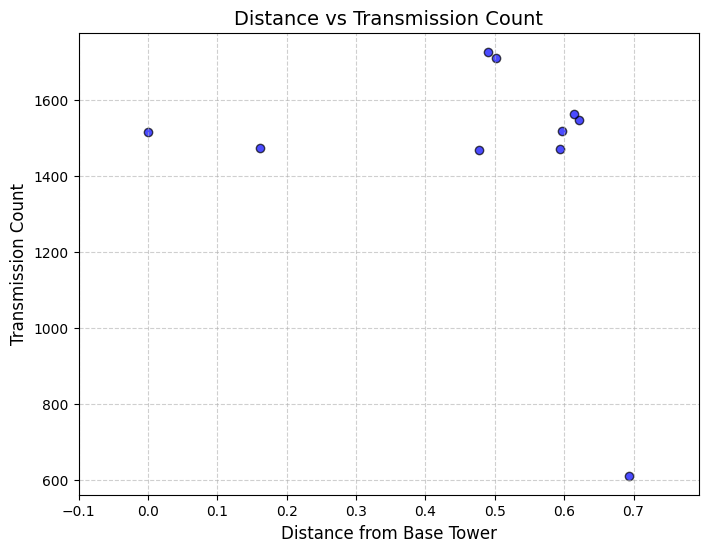

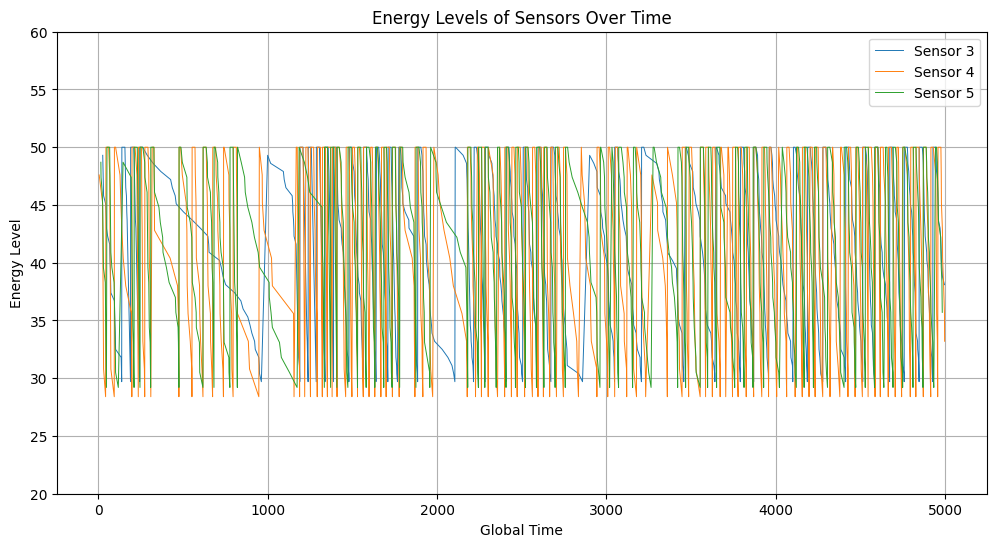

40
94
63
27
39
20
106
40
67
47
CTR 10


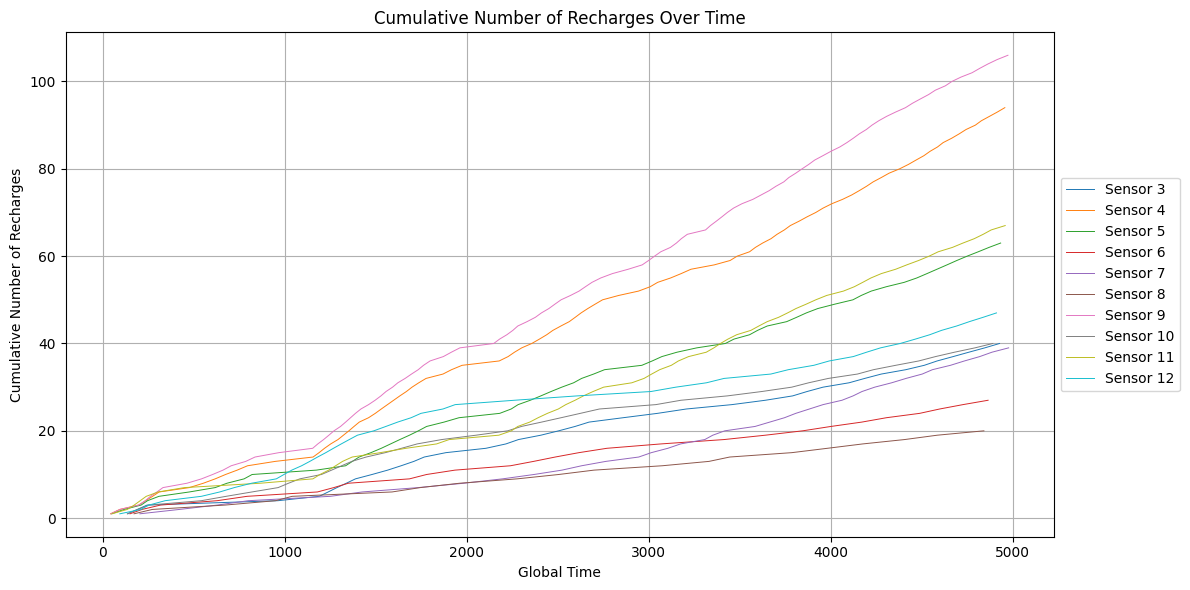

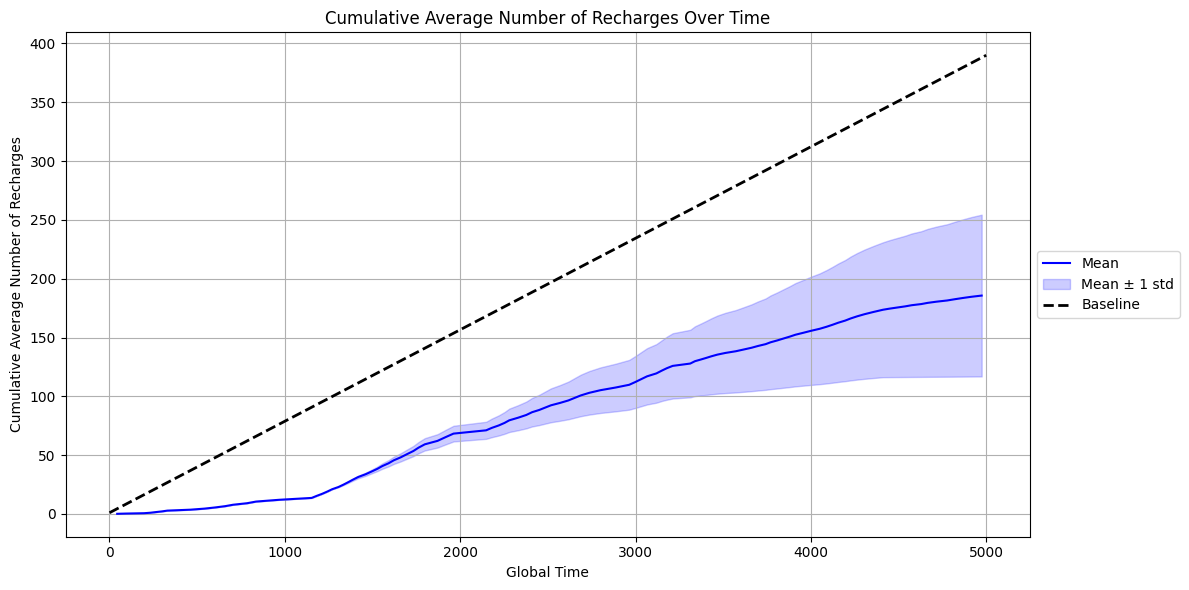

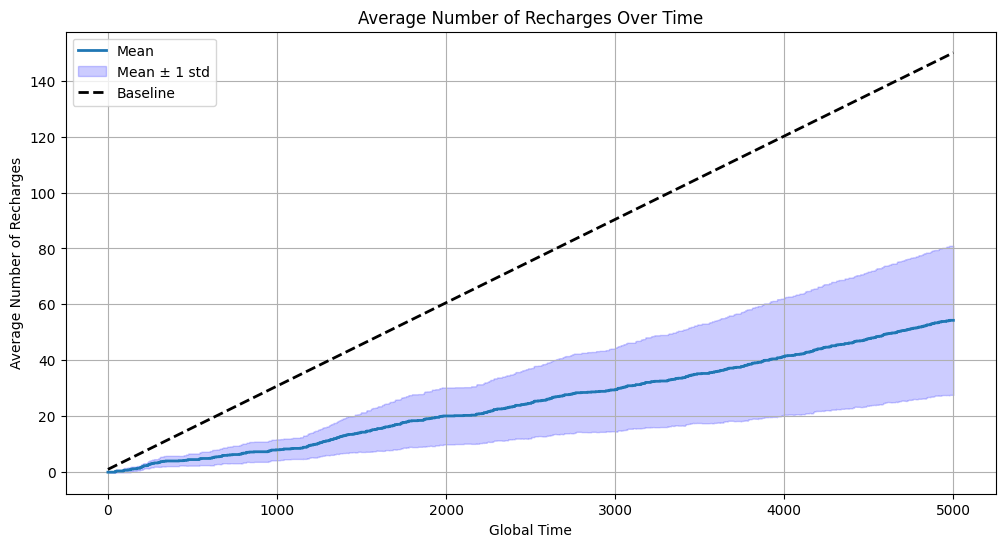

In [ ]:

# Example usage
if __name__ == "__main__":
    # Load your sensor data

    n = 10000  # Replace this with any desired number of rows

    # Load data for debugging (use only the first n rows)
    # towerData_2 = pd.read_csv("post_data/tower2Data_processed.csv").head(n)
    towerData_3 = pd.read_csv("post_data/tower3Data_processed.csv").head(n)
    towerData_4 = pd.read_csv("post_data/tower4Data_processed.csv").head(n)
    towerData_5 = pd.read_csv("post_data/tower5Data_processed.csv").head(n)
    towerData_6 = pd.read_csv("post_data/tower6Data_processed.csv").head(n)
    towerData_7 = pd.read_csv("post_data/tower7Data_processed.csv").head(n)
    towerData_8 = pd.read_csv("post_data/tower8Data_processed.csv").head(n)
    towerData_9 = pd.read_csv("post_data/tower9Data_processed.csv").head(n)
    towerData_10 = pd.read_csv("post_data/tower10Data_processed.csv").head(n)
    towerData_11 = pd.read_csv("post_data/tower11Data_processed.csv").head(n)
    towerData_12 = pd.read_csv("post_data/tower12Data_processed.csv").head(n)



    # Create a dictionary to store all tower data
    sensor_data = {

        3: towerData_3,
        4: towerData_4,
        5: towerData_5,
        6: towerData_6,
        7: towerData_7,
        8: towerData_8,
        9: towerData_9,
        10: towerData_10,
        11: towerData_11,
        12: towerData_12
    }

    # Initialize environment
    env = WSNEnvironment()

    # Add sensors
    for sensor_id in sensor_data.keys():
        env.add_sensor(sensor_id, initial_energy=50, recharge_threshold=30, recharge_time=20)

    # Initialize the RL scheduler
    env.initialize_scheduler(state_size=4, action_size=2, num_levels=2)

    # Run simulation
    env.simulate(sensor_data, n=5000)

    # Plot results
    env.plot_energy_levels()
    env.plot_cumulative_recharges()
    env.plot_single_cumulative_recharges()
    env.plot_average_recharges()
    # env.plot_frequency_distance()
    # env.plot_latest_timestamps()

## Baseline Setup.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque, defaultdict
import random
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

class SensorNode:
    def __init__(self, sensor_id, buffer_size=100, flush_size=10, initial_energy=100, recharge_threshold=20, recharge_time=3):
        # Basic sensor properties
        self.sensor_id = sensor_id
        self.initial_energy = initial_energy
        self.energy = initial_energy
        self.recharge_threshold = recharge_threshold
        self.recharge_time = recharge_time
        self.recharge_count = 0
        self.recharge_end_time = 0

        # Buffer management
        self.buffer = deque(maxlen=buffer_size)
        self.flush_size = flush_size
        self.flush_log = []

        # Monitoring variables
        self.energy_over_time = []
        self.recharge_over_time = []
        self.latest_timestamp_over_time = []
        ###
        self.node_energy = node_energy_
        # RL-specific properties
        self.previous_frequency = 1

    def add_data(self, row, global_time):
        if global_time < self.recharge_end_time:
            self.energy_over_time.append((global_time, self.energy))
            if self.buffer:
                self.latest_timestamp_over_time.append((global_time, self.buffer[-1]['Timestamp']))
            return

        # self.energy -= 1
        self.energy -= self.node_energy[self.sensor_id]
        self.energy_over_time.append((global_time, self.energy))

        self.buffer.append(row)
        self.latest_timestamp_over_time.append((global_time, row['Timestamp']))

        if self.energy < self.recharge_threshold:
            self.recharge(global_time)

        if len(self.buffer) == self.buffer.maxlen:
            self.flush_data()

    def flush_data(self):
        flushed_values = [self.buffer.popleft() for _ in range(self.flush_size)]
        self.flush_log.append(flushed_values)

    def recharge(self, global_time):
        self.recharge_count += 1
        self.energy = self.initial_energy
        self.recharge_end_time = global_time + self.recharge_time
        self.recharge_over_time.append((global_time, self.recharge_count))

    def update_energy(self, global_time):
        if global_time >= self.recharge_end_time:
            self.energy -= self.node_energy[self.sensor_id]
            if self.energy < self.recharge_threshold:
                self.recharge(global_time)

    # def calculate_energy(d, d_0=0.01, K=10, a=1, E_0=0):
    #     return E_0 + K / (1 + np.exp(-a * (d - d_0)))
    # cluster_head = "towerData_1"
    # distances_to_cluster_head = distance_matrix[cluster_head].astype(float)
    # energy_consumption = distances_to_cluster_head.apply(calculate_energy)

class QNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 8)  # Hidden layer with 8 neurons
        self.fc2 = nn.Linear(8, action_size)  # Output layer with Q-values for each action

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

# Updated RLScheduler for DQN
class RLScheduler:
    def __init__(self, num_sensors, state_size, action_size, num_levels):
        self.num_sensors = num_sensors
        self.state_size = state_size
        self.action_size = action_size
        self.num_levels = num_levels

        # Initialize Q-network and target network
        self.q_network = QNetwork(state_size, action_size)
        self.target_network = QNetwork(state_size, action_size)
        self.target_network.load_state_dict(self.q_network.state_dict())  # Sync networks
        self.target_network.eval()

        # Replay buffer
        self.replay_buffer = deque(maxlen=1000)

        # Optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=0.001)

        # Hyperparameters
        self.gamma = 0.9  # Discount factor
        self.batch_size = 32
        self.update_frequency = 10  # Update target network every 10 steps

        self.steps = 0  # Track training steps

    def one_hot_encode(self, state):
        """
        One-hot encode the state. Clamp the state to ensure it is within the valid range.
        """
        state = max(0, min(state, self.state_size - 1))  # Clamp state to valid range
        one_hot = np.zeros(self.state_size)
        one_hot[state] = 1
        return one_hot

    def get_action(self, state, training=True, epsilon=1.0):
        """
        Epsilon-greedy action selection for exploration and exploitation.
        """
        if training and np.random.rand() < epsilon:
            return np.random.choice(self.action_size)  # Exploration
        else:
            state_tensor = torch.FloatTensor([self.one_hot_encode(state)])  # One-hot encode state
            q_values = self.q_network(state_tensor).detach().numpy()
            return np.argmax(q_values)  # Exploitation

    def store_experience(self, state, action, reward, next_state):
        """
        Store experience in the replay buffer.
        """
        self.replay_buffer.append((state, action, reward, next_state))

    def train(self):
        """
        Train the Q-network using experiences from the replay buffer.
        """
        if len(self.replay_buffer) < self.batch_size:
            return  # Not enough samples to train

        # Sample a mini-batch
        batch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states = zip(*batch)

        # Convert to tensors
        states = torch.FloatTensor([self.one_hot_encode(s) for s in states])
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor([self.one_hot_encode(s) for s in next_states])

        # Compute target Q-values
        next_q_values = self.target_network(next_states).max(1)[0]
        targets = rewards + self.gamma * next_q_values

        # Compute current Q-values
        q_values = self.q_network(states).gather(1, actions.view(-1, 1)).squeeze()

        # Compute loss
        loss = nn.MSELoss()(q_values, targets)

        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update target network periodically
        self.steps += 1
        if self.steps % self.update_frequency == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())

    def update_q_value(self, state, action, reward, next_state):
        """
        Add experience to the replay buffer and train the network.
        """
        self.store_experience(state, action, reward, next_state)
        self.train()


class WSNEnvironment:
    def __init__(self):
        self.sensors = {}
        self.global_time = 0
        self.scheduler = None
        self.discrete_threshold = [0.25, 0.50002455, 0.75]

    def add_sensor(self, sensor_id, buffer_size=100, flush_size=10, initial_energy=100, recharge_threshold=20, recharge_time=3):
        self.sensors[sensor_id] = SensorNode(sensor_id, buffer_size, flush_size, initial_energy, recharge_threshold, recharge_time)

    def initialize_scheduler(self, state_size, action_size, num_levels):


        self.scheduler = RLScheduler(
            num_sensors=len(self.sensors),
            state_size=state_size,
            action_size=action_size,
            num_levels=num_levels
        )

        print("  Scheduler created successfully")


    def calculate_reward(self,sensor_id, f_i, discrete_similarity, lambda_param=0.01):
        reward = -1 * (discrete_similarity)
        reward += (-(f_i) * 0.01)
        reward += -1 * (normalized_z_scores_dict[sensor_id]) * 0.6
        return reward

    def calculate_similarity(self, sensor_data, step):
        """
        Calculate similarities between sensors at a given time step

        Args:
            sensor_data (dict): Dictionary of sensor dataframes
            step (int): Current time step

        Returns:
            dict: Similarities between sensor pairs
        """
        # Round temperature values to 3 decimal places
        rounded_values = {
            sensor_id: round(df.loc[step, "Temperature_2m"], 3)
            for sensor_id, df in sensor_data.items()
        }

        # Compute similarities
        similarities = {}
        sensor_ids = list(rounded_values.keys())

        for i in range(len(sensor_ids)):
            for j in range(i + 1, len(sensor_ids)):
                sensor_i = sensor_ids[i]
                sensor_j = sensor_ids[j]

                # Simple dot product similarity
                value_i = rounded_values[sensor_i]
                value_j = rounded_values[sensor_j]

                # Compute dot product similarity
                similarity = abs(value_i * value_j) / (abs(value_i) + abs(value_j) + 1e-10)

                similarities[(sensor_i, sensor_j)] = similarity

        return similarities




    def calculate_similarity_score(self, sensor_id, similarites, alpha=1, beta=1):
        similarity = 0.0
        n = len(similarites)
        for (i, j), jaccard in similarites.items():
            if sensor_id == i or sensor_id == j:
                similarity += alpha * jaccard
        aggregated_similarity = similarity / max(n, 1)
        buffer_margin=0.01
        # Define robust min and max (static or dynamic)
        current_min = 0.0227  # Replace with observed min_similarity or predefined value
        current_max = 0.0826  # Replace with observed max_similarity or predefined value
        min_similarity = current_min - buffer_margin
        max_similarity = current_max + buffer_margin

        # Clamp values to handle outliers
        clamped_similarity = max(min(aggregated_similarity, max_similarity), min_similarity)

        # Normalize to range [0, 1]
        normalized_similarity = (clamped_similarity - min_similarity) / (max_similarity - min_similarity)

        return normalized_similarity
    def get_similarity_level(self, similarity_value):
        """
        Map a single similarity value to its corresponding level based on class variable discrete_threshold.

        Args:
            similarity_value (float): The similarity value to map to a level.

        Returns:
            int: The level corresponding to the similarity value.
        """
        for i, threshold in enumerate(self.discrete_threshold):
            if similarity_value < threshold:
                return i + 1
        return len(self.discrete_threshold) + 1

    def determine_usage(self, sensor_data, n_steps, alpha=0.1, beta=0.1, lambda_param=0.1, training=True):
        """
        Determine sensor transmission usage with comprehensive debug info

        Args:
            sensor_data (dict): Dictionary of sensor dataframes
            n_steps (int): Number of time steps to simulate
            alpha (float): Weight for unique data reward
            beta (float): Weight for similarity penalty
            lambda_param (float): Energy conservation parameter
            training (bool): Whether in training mode

        Returns:
            list: Usage array with transmission decisions for each sensor at each time step
        """
        # Initialize usage array with zeros
        usage_array = [[0 for _ in range(n_steps)] for _ in range(len(sensor_data))]
        sensor_ids = list(sensor_data.keys())


        similarity_stats = []
        jaccard_stats = []
        level_counts = {level: 0 for level in range(1, len(self.discrete_threshold) + 2)}
        sensor_level_counts = {
        sensor_id: {level: 0 for level in range(1, len(self.discrete_threshold) + 2)}
        for sensor_id in sensor_data.keys()
        }



        for step in range(n_steps):

            jaccard_similarities = self.calculate_similarity(sensor_data, step)
            # print("Raw Similarity: ", jaccard_similarities)
            jaccard_stats.extend(jaccard_similarities.values())

            for sensor_id in sensor_data.keys():
                similarity = self.calculate_similarity_score(sensor_id, jaccard_similarities, alpha, beta)
                level = self.get_similarity_level(similarity)
                #######PRINT STATEMETS#########
                level_counts[level] += 1
                sensor_level_counts[sensor_id][level] += 1
                similarity_stats.append(similarity)
                #######PRINT STATEMETS#########
                state = level

                action = self.scheduler.get_action(state, training=training)
                # reward = -1 * (level)
                # reward += (-(action) * 0.01)
                reward = self.calculate_reward(sensor_id,action, level)



                # if sensor_id == 4:
                #     reward -= 10
                next_state = state
                self.scheduler.update_q_value(state, action, reward, next_state)
                # Update usage array based on action (e.g., action 1 = transmit)
                usage_array[list(sensor_data.keys()).index(sensor_id)][step] = action


        # Convert to a NumPy array for easier analysis
        similarity_stats = np.array(similarity_stats)
        jaccard_stats = np.array(jaccard_stats)

        # Calculate statistics across steps for similarity scores
        mean_similarity = np.mean(similarity_stats)
        std_similarity = np.std(similarity_stats)
        min_similarity = np.min(similarity_stats)
        max_similarity = np.max(similarity_stats)
        n_levels = 4
        bins = np.linspace(min_similarity, max_similarity, n_levels + 1)
        discretized_levels = np.digitize(similarity_stats, bins, right=False)

        # # Count the number of values in each level
        # level_counts = {level: np.sum(discretized_levels == level) for level in range(1, n_levels + 1)}

        # Print the counts
        # print(f"\nDiscretized Similarity Levels (n_levels={n_levels}):")
        # for level, count in level_counts.items():
        #     print(f"  Level {level}: {count} values")
        print(f"Discretization Thresholds (n_levels={n_levels}): {bins}")
        print(f"\nDiscretized Similarity Levels (based on {len(self.discrete_threshold)} thresholds):")
        for level, count in level_counts.items():
            print(f"  Level {level}: {count} values")
        # print(f"\nSensor-Specific Level Counts:")
        # for sensor_id, counts in sensor_level_counts.items():
        #     print(f"  Sensor {sensor_id}:")
        #     for level, count in counts.items():
        #         print(f"    Level {level}: {count} times")

        # Print overall statistics for similarity scores
        print("\nOverall Similarity Statistics Across Steps:")
        print(f"  Mean Similarity: {mean_similarity:.4f}")
        print(f"  Std Deviation: {std_similarity:.4f}")
        print(f"  Min Similarity: {min_similarity:.4f}")
        print(f"  Max Similarity: {max_similarity:.4f}")

        # Calculate aggregated statistics for Jaccard similarities across steps
        mean_jaccard = np.mean(jaccard_stats)
        std_jaccard = np.std(jaccard_stats)
        min_jaccard = np.min(jaccard_stats)
        max_jaccard = np.max(jaccard_stats)

        # Print overall statistics for Jaccard similarities
        print("\nOverall Jaccard Similarity Statistics Across Steps:")
        print(f"  Mean Jaccard Similarity: {mean_jaccard:.4f}")
        print(f"  Std Deviation: {std_jaccard:.4f}")
        print(f"  Min Jaccard Similarity: {min_jaccard:.4f}")
        print(f"  Max Jaccard Similarity: {max_jaccard:.4f}")
        print(f"Total 0's: {sum(row.count(0) for row in usage_array)}, Total 1's: {sum(row.count(1) for row in usage_array)}")
        high_frequency = sum(row.count(1) for row in usage_array)
        percent_high_frequency = high_frequency / (high_frequency + sum(row.count(0) for row in usage_array)) * 100
        print("Percentage of actions in High Frequency: ", percent_high_frequency)
        return usage_array

    def simulate(self, sensor_data, n):
        num_rows = min(len(df) for df in sensor_data.values())
        iterations = min(n, num_rows)

        # Determine the usage array using RL
        usage_array = self.determine_usage(sensor_data, iterations)

        # Get total unique values across all sensors
        total_values = set()
        transmitted_values = set()

        # Track data points
        for row_index in tqdm(range(iterations), desc="Simulating data collection", unit="step"):
            for sensor_id, df in sensor_data.items():
                # Round to first decimal place and add to total values
                value = round(df.iloc[row_index]['Temperature_2m'], 6)
                total_values.add(value)

                # If transmission is allowed, add to transmitted values
                sensor_index = list(sensor_data.keys()).index(sensor_id)
                if usage_array[sensor_index][row_index] == 1:
                    transmitted_values.add(value)
                    row_data = df.iloc[row_index]
                    self.add_data(sensor_id, row_data)
            self.global_time += 1

        # Calculate transmission counts for each sensor
        transmission_counts = {
            sensor_id: np.sum(usage_array[list(sensor_data.keys()).index(sensor_id)])
            for sensor_id in sensor_data.keys()
        }

        # Print transmission statistics
        print("\nSensor Transmission Counts:")
        for sensor_id, count in transmission_counts.items():
            print(f"Sensor {sensor_id}: {count} transmissions")

        # Print data loss statistics
        total_unique = len(total_values)
        transmitted_unique = len(transmitted_values)
        lost_unique = total_unique - transmitted_unique

        print(f"\nData Loss Analysis:")
        print(f"Total unique temperature readings: {total_unique}")
        print(f"Transmitted unique temperature readings: {transmitted_unique}")
        print(f"Lost unique temperature readings: {lost_unique}")
        print(f"Percentage of unique readings preserved: {(transmitted_unique/total_unique)*100:.2f}%")
        print(f"Percentage of unique readings lost: {(lost_unique/total_unique)*100:.2f}%")

        distances = []
        transmissions = []

        for sensor, distance in distances_from_base.items():
            sensor_id = int(sensor.split('_')[1])  # Extract the sensor ID as an integer
            if sensor_id in transmission_counts:
                distances.append(distance)
                transmissions.append(transmission_counts[sensor_id])

        # Create the scatter plot
        plt.figure(figsize=(8, 6))
        plt.scatter(distances, transmissions, color='blue', edgecolor='black', alpha=0.7)

        # Set viewing limits for better legibility
        plt.xlim(min(distances) - 0.1, max(distances) + 0.1)
        plt.ylim(min(transmissions) - 50, max(transmissions) + 50)

        # Add labels and title
        plt.xlabel('Distance from Base Tower', fontsize=12)
        plt.ylabel('Transmission Count', fontsize=12)
        plt.title('Distance vs Transmission Count', fontsize=14)

        # Add grid for better readability
        plt.grid(True, linestyle='--', alpha=0.6)

        plt.show()


    def add_data(self, sensor_id, row):
        if sensor_id not in self.sensors:
            raise ValueError(f"Sensor ID {sensor_id} is not valid.")
        self.sensors[sensor_id].add_data(row, self.global_time)

    def plot_energy_levels(self):
        plt.figure(figsize=(12, 6))
        i = 0
        for sensor_id, sensor in (self.sensors.items()):
            if i > 2:
                break
            time, energy = zip(*sensor.energy_over_time)
            plt.plot(time, energy, marker='o', markersize=0, linestyle='-', linewidth=0.7, label=f'Sensor {sensor_id}')
            i += 1
        plt.xlabel('Global Time')
        plt.ylabel('Energy Level')
        plt.title('Energy Levels of Sensors Over Time')
        plt.legend()
        plt.grid(True)
        plt.ylim(20, 60)
        # plt.xlim(100, 400)
        plt.show()

    def plot_cumulative_recharges(self):
        plt.figure(figsize=(12, 6))
        ctr = 0
        # Plot actual cumulative recharges for each sensor
        for sensor_id, sensor in self.sensors.items():
            time, recharge_count = zip(*sensor.recharge_over_time) if sensor.recharge_over_time else ([], [])
            ctr+=1
            print(len(sensor.recharge_over_time))
            plt.plot(time, recharge_count, marker='o', markersize=0, linestyle='-', linewidth=0.7, label=f'Sensor {sensor_id}')
        # print("l rcovt", len(sensor.re))
        print("CTR", ctr)
        # Plot labels and legend
        plt.xlabel('Global Time')
        plt.ylabel('Cumulative Number of Recharges')
        plt.title('Cumulative Number of Recharges Over Time')

        # Adjust the legend to be on the side
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        plt.grid(True)
        plt.tight_layout()  # Ensure everything fits without overlapping
        plt.show()

    def plot_single_cumulative_recharges(self):
            plt.figure(figsize=(12, 6))

            # Get the cumulative recharges for all sensors
            all_recharges = []
            max_time = 0
            global_time = None  # To capture the global time for alignment
            for sensor in self.sensors.values():
                time, recharge_count = zip(*sensor.recharge_over_time) if sensor.recharge_over_time else ([], [])
                all_recharges.append(recharge_count)
                if global_time is None or len(time) > len(global_time):
                    global_time = time
                max_time = max(max_time, len(recharge_count))

            # Align all recharge sequences to the same length by padding with 0s
            aligned_recharges = []
            for recharge in all_recharges:
                aligned_recharges.append(np.pad(recharge, (0, max_time - len(recharge)), constant_values=0))
            aligned_recharges = np.array(aligned_recharges, dtype=float)
            aligned_recharges = aligned_recharges/10
            # Calculate the mean and standard deviation at each time point
            mean_recharges = np.mean(aligned_recharges, axis=0)  # Mean of values across sensors
            std_recharges = np.std(aligned_recharges, axis=0)   # Std deviation of values across sensors

            # Calculate the cumulative sum for mean and std deviation
            cumulative_mean_recharges = np.cumsum(mean_recharges)
            cumulative_std_recharges = np.cumsum(std_recharges) / np.sqrt(len(self.sensors))  # Adjust std for averaging

            # Plot the mean +/- 1 standard deviation
            plt.plot(global_time, cumulative_mean_recharges, color='blue', label='Mean')
            # plt.fill_between(
            #     global_time,
            #     cumulative_mean_recharges - cumulative_std_recharges,
            #     cumulative_mean_recharges + cumulative_std_recharges,
            #     color='blue',
            #     alpha=0.2,
            #     label='Mean ± 1 std'
            # )
            baseline_time = range(self.global_time + 1)  # Time steps from 0 to global time
            baseline_recharges = [1 + (t * (390 - 1) / self.global_time) for t in baseline_time]
            plt.plot(
                baseline_time,
                baseline_recharges,
                linestyle='--',
                linewidth=2,
                color='black',
                label='Baseline'
            )

            # Plot labels and legend
            plt.xlabel('Global Time')
            plt.ylabel('Cumulative Average Number of Recharges')
            plt.title('Cumulative Average Number of Recharges Over Time')
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    def plot_average_recharges(self):
        plt.figure(figsize=(12, 6))

        # Initialize lists for average and standard deviation of recharges
        average_recharges_over_time = []
        std_recharges_over_time = []

        max_time = self.global_time

        for time in range(max_time + 1):
            recharge_counts_at_time = []

            # Calculate total and individual recharges at this time step
            for sensor in self.sensors.values():
                recharge_count = sum(t <= time for t, _ in sensor.recharge_over_time)
                recharge_counts_at_time.append(recharge_count)

            # Compute mean and std at this time step
            average_recharges = np.mean(recharge_counts_at_time)
            std_recharges = np.std(recharge_counts_at_time)

            average_recharges_over_time.append(average_recharges)
            std_recharges_over_time.append(std_recharges)

        time_steps = range(max_time + 1)

        # Plot the average recharges over time
        plt.plot(time_steps, average_recharges_over_time, linestyle='-', linewidth=2, label='Mean')

        # Add fill_between for mean ± 1 std
        upper_bound = np.array(average_recharges_over_time) + np.array(std_recharges_over_time)
        lower_bound = np.array(average_recharges_over_time) - np.array(std_recharges_over_time)



        # Add labels and title
        plt.xlabel('Global Time')
        plt.ylabel('Average Number of Recharges')
        plt.title('Average Number of Recharges Over Time')
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.show()



def sigmoid(x):
    return 1 / (1 + np.exp(-x))


### Running Baseline

  Scheduler created successfully
Discretization Thresholds (n_levels=4): [0.   0.25 0.5  0.75 1.  ]

Discretized Similarity Levels (based on 3 thresholds):
  Level 1: 8100 values
  Level 2: 14195 values
  Level 3: 21515 values
  Level 4: 6190 values

Overall Similarity Statistics Across Steps:
  Mean Similarity: 0.4936
  Std Deviation: 0.2083
  Min Similarity: 0.0000
  Max Similarity: 1.0000

Overall Jaccard Similarity Statistics Across Steps:
  Mean Jaccard Similarity: 2.6022
  Std Deviation: 1.2718
  Min Jaccard Similarity: 0.0227
  Max Jaccard Similarity: 6.7227
Total 0's: 24973, Total 1's: 25027
Percentage of actions in High Frequency:  50.054


Simulating data collection: 100%|██████████| 5000/5000 [00:01<00:00, 3923.16step/s]



Sensor Transmission Counts:
Sensor 3: 2449 transmissions
Sensor 4: 2491 transmissions
Sensor 5: 2501 transmissions
Sensor 6: 2500 transmissions
Sensor 7: 2433 transmissions
Sensor 8: 2553 transmissions
Sensor 9: 2545 transmissions
Sensor 10: 2512 transmissions
Sensor 11: 2506 transmissions
Sensor 12: 2537 transmissions

Data Loss Analysis:
Total unique temperature readings: 1596
Transmitted unique temperature readings: 1580
Lost unique temperature readings: 16
Percentage of unique readings preserved: 99.00%
Percentage of unique readings lost: 1.00%


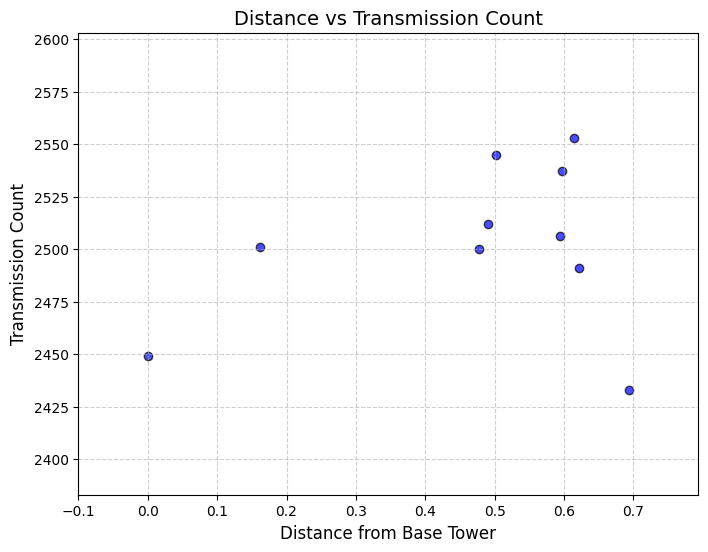

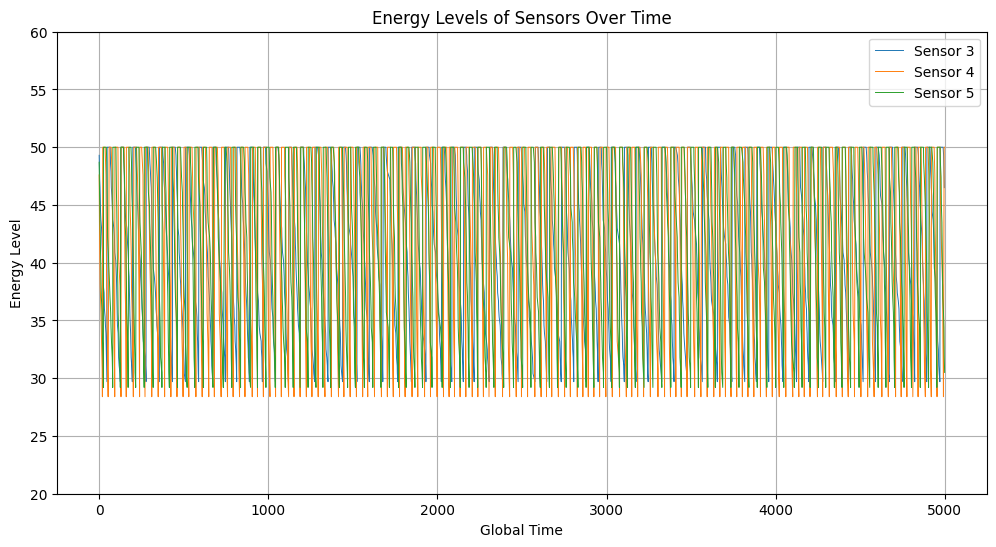

64
137
98
46
116
33
144
58
106
78
CTR 10


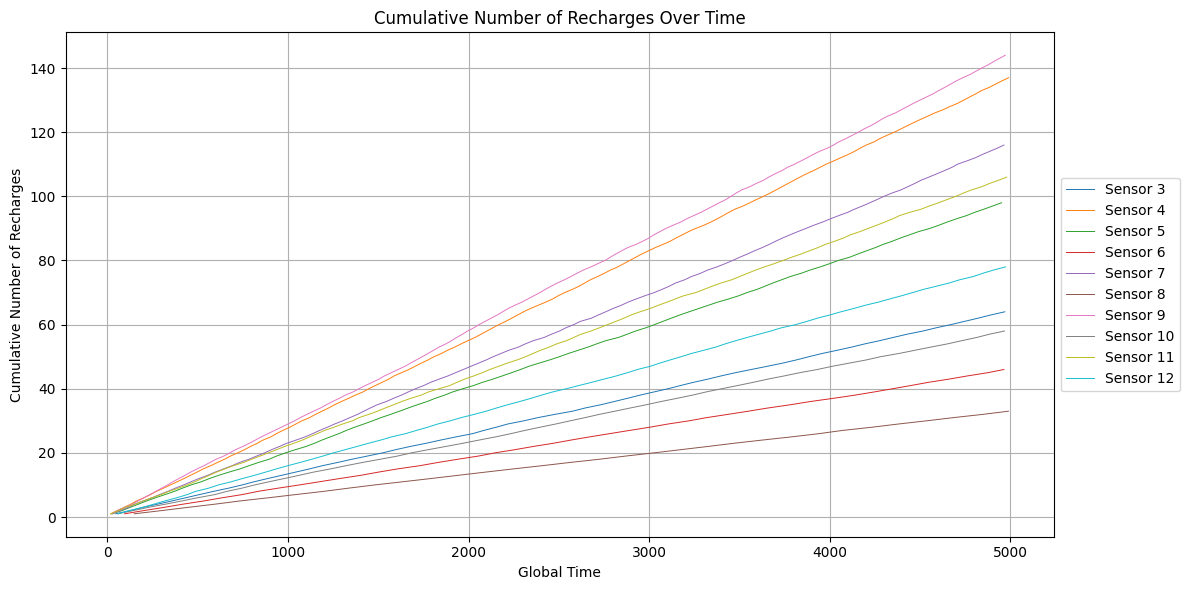

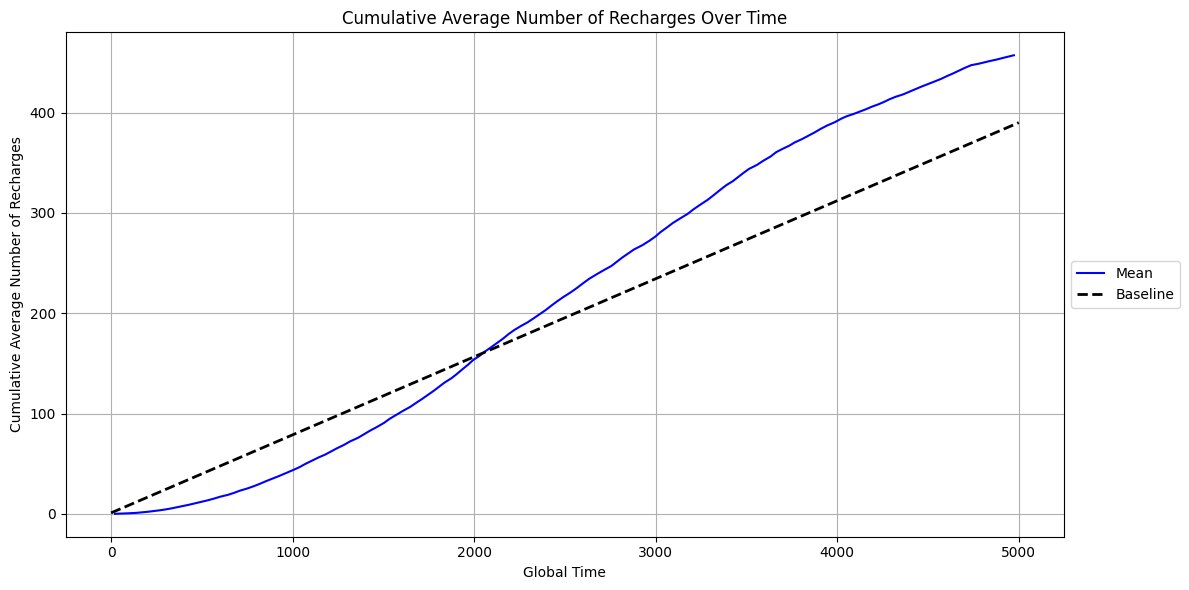

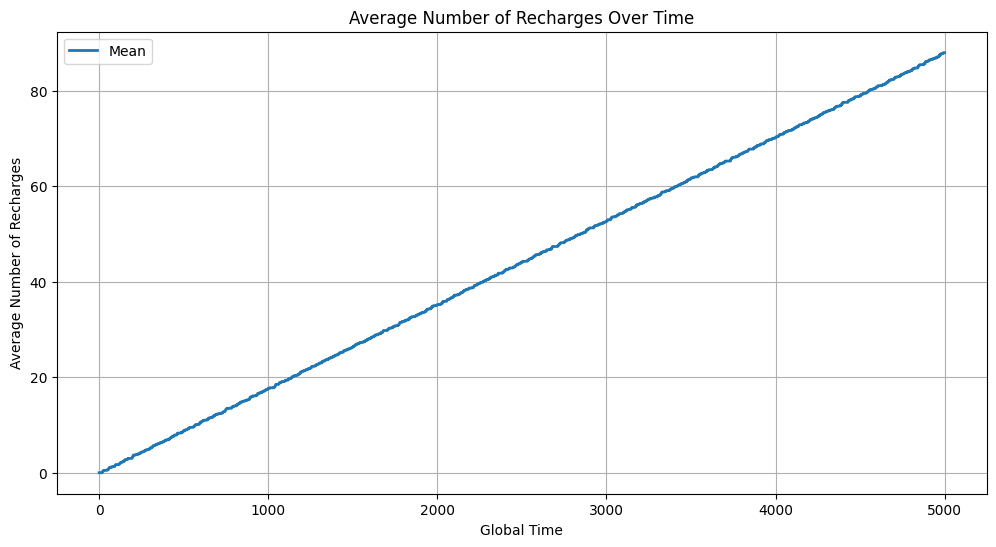

In [ ]:

# Example usage
if __name__ == "__main__":
    # Load your sensor data

    n = 10000  # Replace this with any desired number of rows

    # Load data for debugging (use only the first n rows)
    # towerData_2 = pd.read_csv("post_data/tower2Data_processed.csv").head(n)
    towerData_3 = pd.read_csv("post_data/tower3Data_processed.csv").head(n)
    towerData_4 = pd.read_csv("post_data/tower4Data_processed.csv").head(n)
    towerData_5 = pd.read_csv("post_data/tower5Data_processed.csv").head(n)
    towerData_6 = pd.read_csv("post_data/tower6Data_processed.csv").head(n)
    towerData_7 = pd.read_csv("post_data/tower7Data_processed.csv").head(n)
    towerData_8 = pd.read_csv("post_data/tower8Data_processed.csv").head(n)
    towerData_9 = pd.read_csv("post_data/tower9Data_processed.csv").head(n)
    towerData_10 = pd.read_csv("post_data/tower10Data_processed.csv").head(n)
    towerData_11 = pd.read_csv("post_data/tower11Data_processed.csv").head(n)
    towerData_12 = pd.read_csv("post_data/tower12Data_processed.csv").head(n)



    # Create a dictionary to store all tower data
    sensor_data = {

        3: towerData_3,
        4: towerData_4,
        5: towerData_5,
        6: towerData_6,
        7: towerData_7,
        8: towerData_8,
        9: towerData_9,
        10: towerData_10,
        11: towerData_11,
        12: towerData_12
    }

    # Initialize environment
    env_baseline = WSNEnvironment()

    # Add sensors
    for sensor_id in sensor_data.keys():
        env_baseline.add_sensor(sensor_id, initial_energy=50, recharge_threshold=30, recharge_time=20)

    # Initialize the RL scheduler
    env_baseline.initialize_scheduler(state_size=4, action_size=2, num_levels=2)

    # Run simulation
    env_baseline.simulate(sensor_data, n=5000)

    # Plot results
    env_baseline.plot_energy_levels()
    env_baseline.plot_cumulative_recharges()
    env_baseline.plot_single_cumulative_recharges()
    env_baseline.plot_average_recharges()
    # env.plot_frequency_distance()
    # env.plot_latest_timestamps()

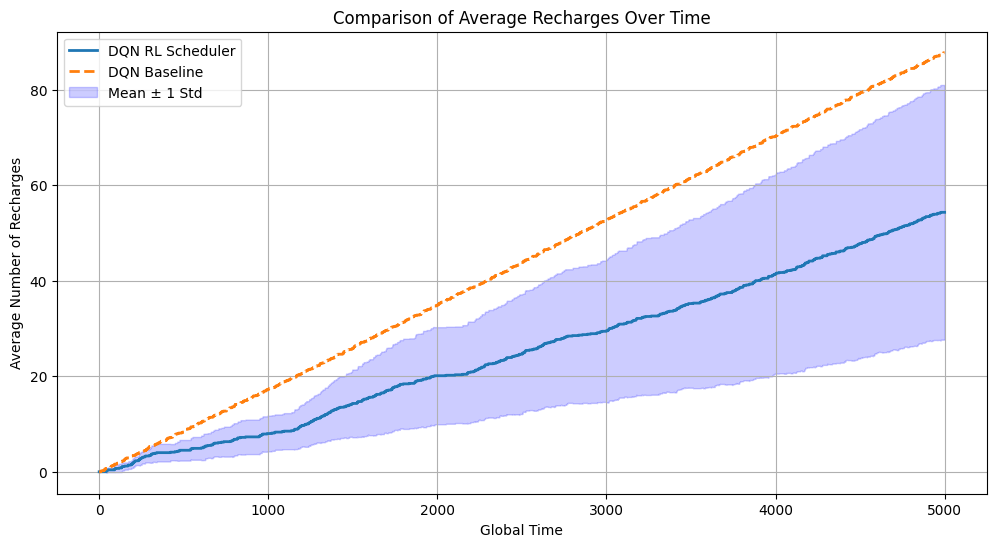

In [ ]:
def plot_combined_average_recharges(env1, env2):
    """
    Combines the average recharges over time from two environments into a single plot.

    Args:
        env1: WSNEnvironment object for the first simulation.
        env2: WSNEnvironment object for the second simulation.
    """
    plt.figure(figsize=(12, 6))

    # Process first environment
    avg_recharges_env1 = []
    std_recharges_env1 = []
    max_time_env1 = env1.global_time
    for time in range(max_time_env1 + 1):
        recharge_counts = [sum(t <= time for t, _ in sensor.recharge_over_time) for sensor in env1.sensors.values()]
        avg_recharges_env1.append(np.mean(recharge_counts))
        std_recharges_env1.append(np.std(recharge_counts))
    time_steps_env1 = range(max_time_env1 + 1)

    # Process second environment
    avg_recharges_env2 = []
    std_recharges_env2 = []
    max_time_env2 = env2.global_time
    for time in range(max_time_env2 + 1):
        recharge_counts = [sum(t <= time for t, _ in sensor.recharge_over_time) for sensor in env2.sensors.values()]
        avg_recharges_env2.append(np.mean(recharge_counts))
        std_recharges_env2.append(np.std(recharge_counts))
    time_steps_env2 = range(max_time_env2 + 1)

    # Plot average recharges for both environments
    plt.plot(time_steps_env1, avg_recharges_env1, label='DQN RL Scheduler', linestyle='-', linewidth=2)
    plt.plot(time_steps_env2, avg_recharges_env2, label='DQN Baseline', linestyle='--', linewidth=2)

    # Add fill_between for mean ± 1 std for env1
    plt.fill_between(
        time_steps_env1,
        np.array(avg_recharges_env1) - np.array(std_recharges_env1),
        np.array(avg_recharges_env1) + np.array(std_recharges_env1),
        color='blue',
        alpha=0.2,
        label='Mean ± 1 Std'
    )

    # # Add fill_between for mean ± 1 std for env2
    # plt.fill_between(
    #     time_steps_env2,
    #     np.array(avg_recharges_env2) - np.array(std_recharges_env2),
    #     np.array(avg_recharges_env2) + np.array(std_recharges_env2),
    #     color='orange',
    #     alpha=0.2,
    #     label='Env 2 Mean ± 1 Std'
    # )

    # Add labels, title, and legend
    plt.xlabel('Global Time')
    plt.ylabel('Average Number of Recharges')
    plt.title('Comparison of Average Recharges Over Time')
    plt.legend(loc='upper left')
    plt.grid(True)

    # Show the combined plot
    plt.show()
plot_combined_average_recharges(env, env_baseline)


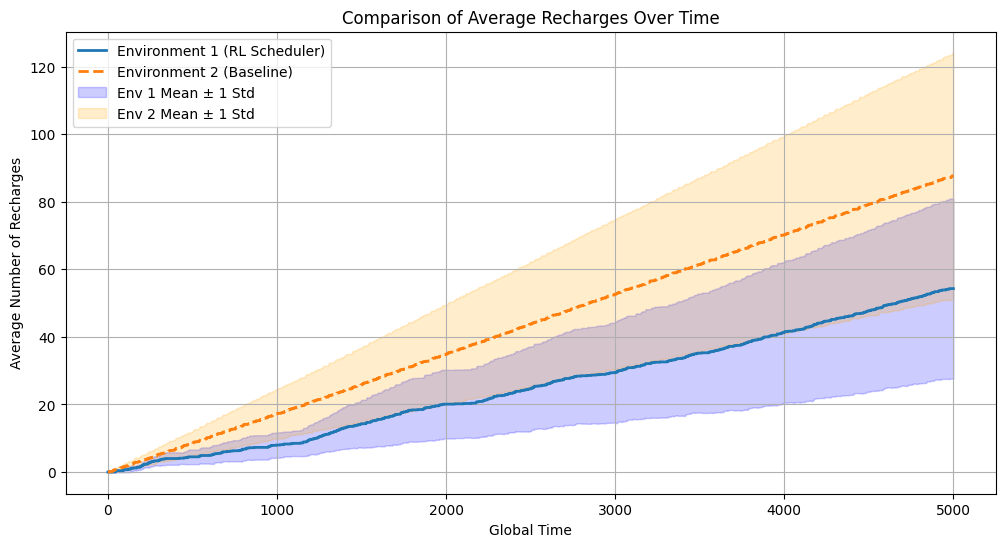

k


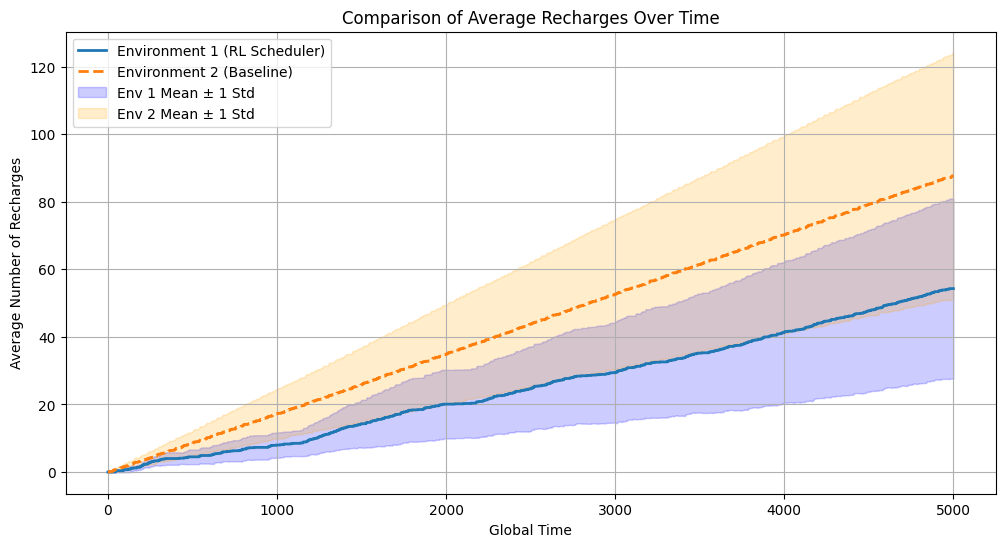

## Combined Graphs